In [79]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas
import experiments.fitting as fitter

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy


Set save data

In [4]:
save_data = True

In [5]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
expt_path=os.path.join(os.getcwd(),'data', 'data_231212')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_231212


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


Load config

In [87]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

# print(list(im))
# print(im)

In [10]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 15.0


In [11]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.207
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

# Qubit/resonator to probe

In [13]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [80]:
qubit_i = 2
results_Qi = all_results[qubit_i]

# RFSoC Calibration

In [268]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i]-15, # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 950 +/- 77.93933333000001


  0%|          | 0/1000 [00:00<?, ?it/s]

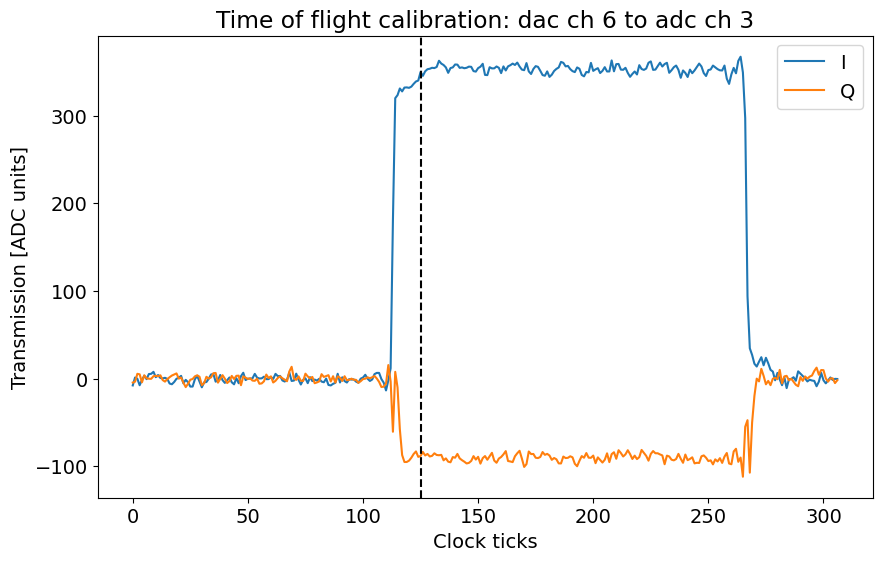

In [269]:
tof.display(adc_trig_offset=125)

# Initial single tone resonator spectroscopy

In [291]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2.0 # MHz
npts = 250
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=2000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
rspec.cfg.device.readout.gain[qubit_i] = 0.3
rspec.cfg.device.readout.relax_delay = 25 # Wait time between experiments [us] - should be 5x resonator lifetime for good shape

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/250 [00:00<?, ?it/s]

[824.3083666666668, 5000, 1000, 0, 29.697674206394264, 46.64294034422282, 1.3521333622387006]
5925.0
950
824.3083666666668

Freq with minimum transmission: 824.3763666666666
Freq with maximum transmission: 825.0003666666667
From fit:
	f0: 7699.308366666666
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: 9.23917004
	phi [radians]: 0


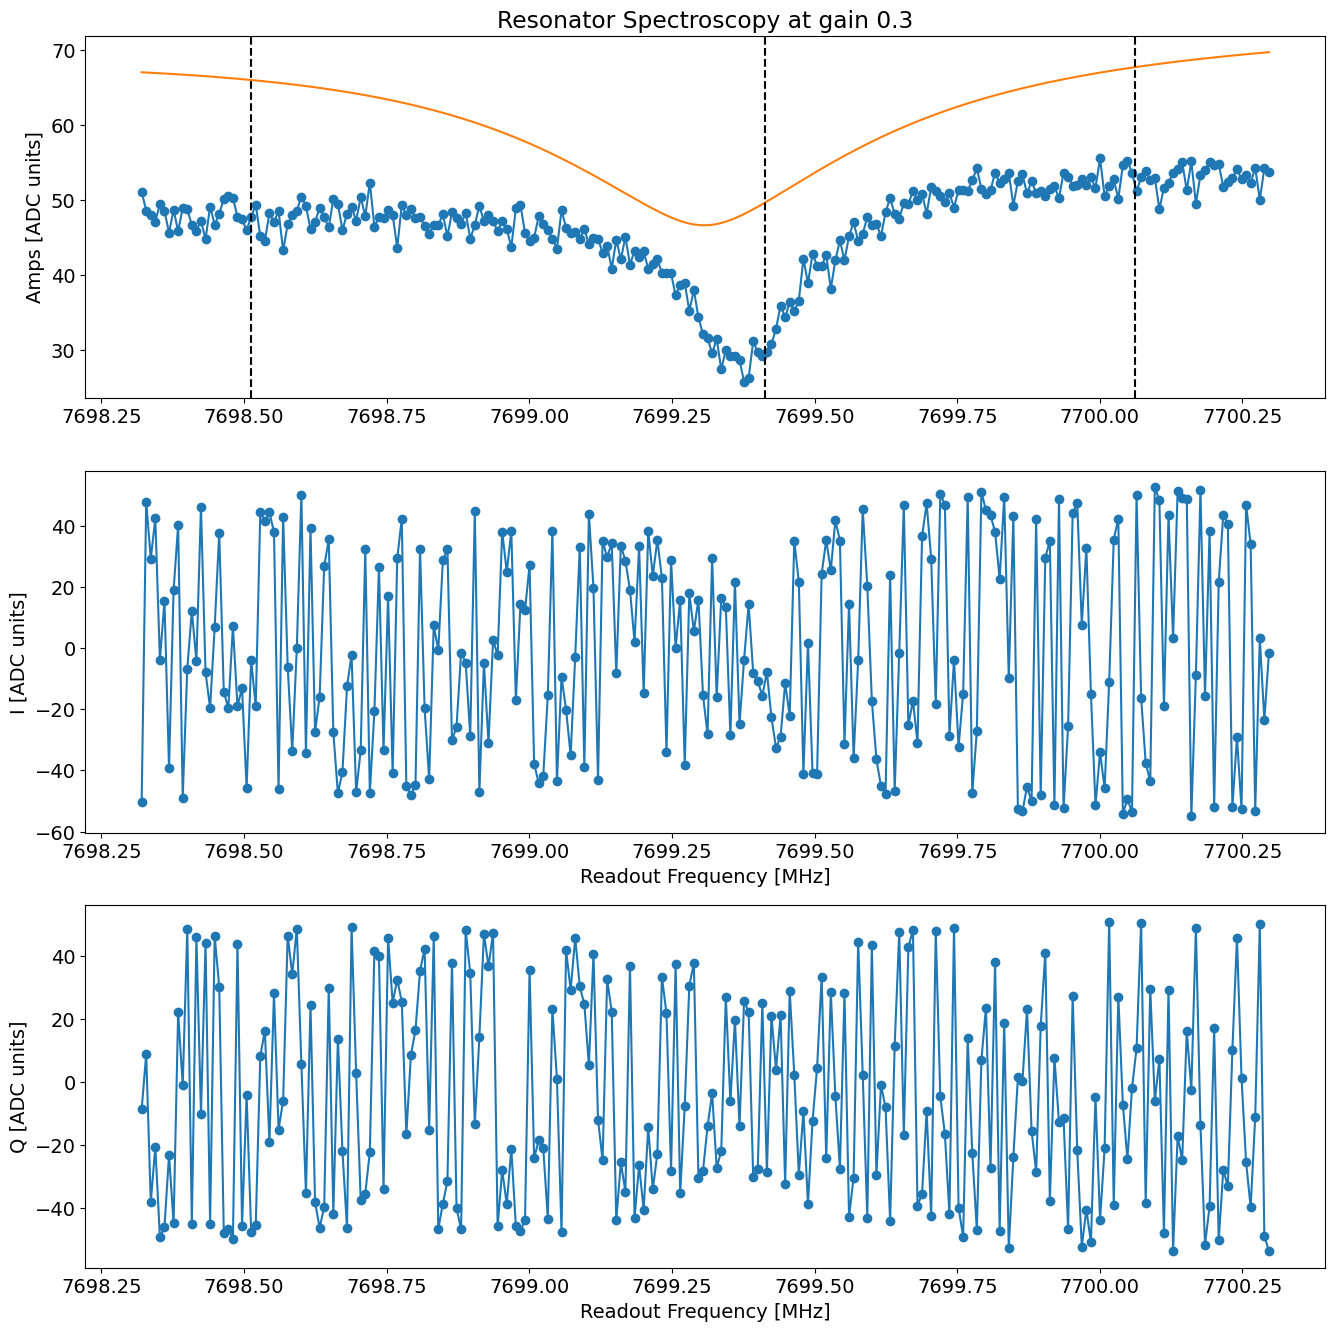

*Set cfg res 2 freq to 824.3763666666666*
*Set cfg res 2 gain to 0.3*
{'Qubit freq': 4767.359704214145, 'Pi pulse len': 0.020886833661091352, 'Pi pulse gain': 2705, 'T1': 32.93056755583473, 'T1 err': 1.2325694970800454, 'T2R': 12.882410694681475, 'T2R err': 1.4701638837441797, 'T2E': 17.77399784383835, 'T2E err': 0.9103708488638977, 'Res chi shift (e - g)': 1.6390728476820868, 'Qubit EF freq': 4577.689960511519, 'EF pi pulse len': 0.022312951557475664, 'EF pi pulse gain': 1859, 'Qubit temp [mK]': 80.94855045625054, 'Single shot g-e fidelity (%)': 15.880529350978364, 'Res freq': 7699.376366666666, 'Res kappa': 0.9891700400000002}


In [292]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]

yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
# yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmax(rspec.data['amps'])]

yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain[qubit_i]
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(results_Qi)

In [23]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00000_resonator_spectroscopy_qubit0.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [45]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 300

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/5), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4115.532206769413, HWHM -0.611527790990073
Found peak in I at [MHz] 4115.459540302904, HWHM -0.5709121302347313
Found peak in Q at [MHz] 4115.5520010984965, HWHM -0.6138507753077643


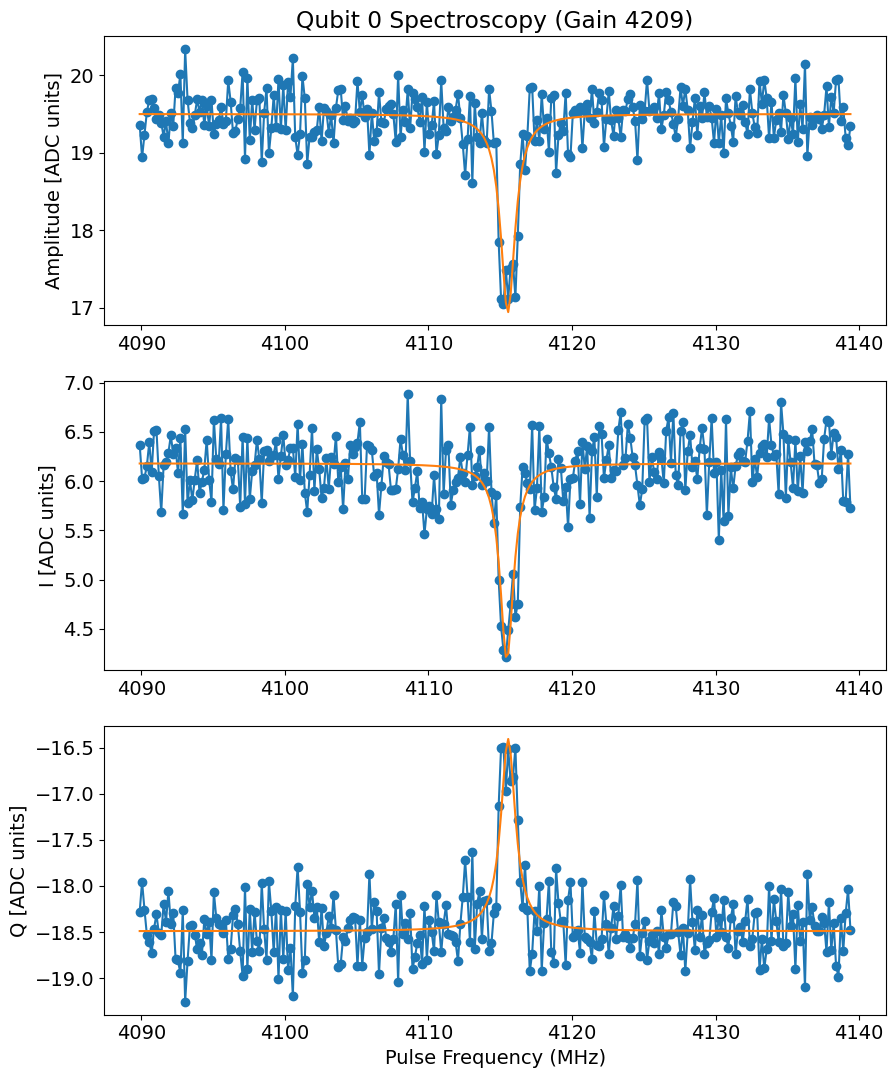

*Set qubit 0 f_ge to 4115.532206769413*
{'Qubit freq': 4115.532206769413}


In [46]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(results_Qi)

In [306]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00000_qubit_spectroscopy_qubit3.h5


## Pulse Probe (qubit) spectroscopy round 2

In [21]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 10
npts = 350

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=40, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/50), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4766.473417405615, HWHM 0.3156755012514176
Found peak in I at [MHz] 4766.8248016694715, HWHM 0.7046180422069874
Found peak in Q at [MHz] 4766.545057647505, HWHM 0.501514692346077


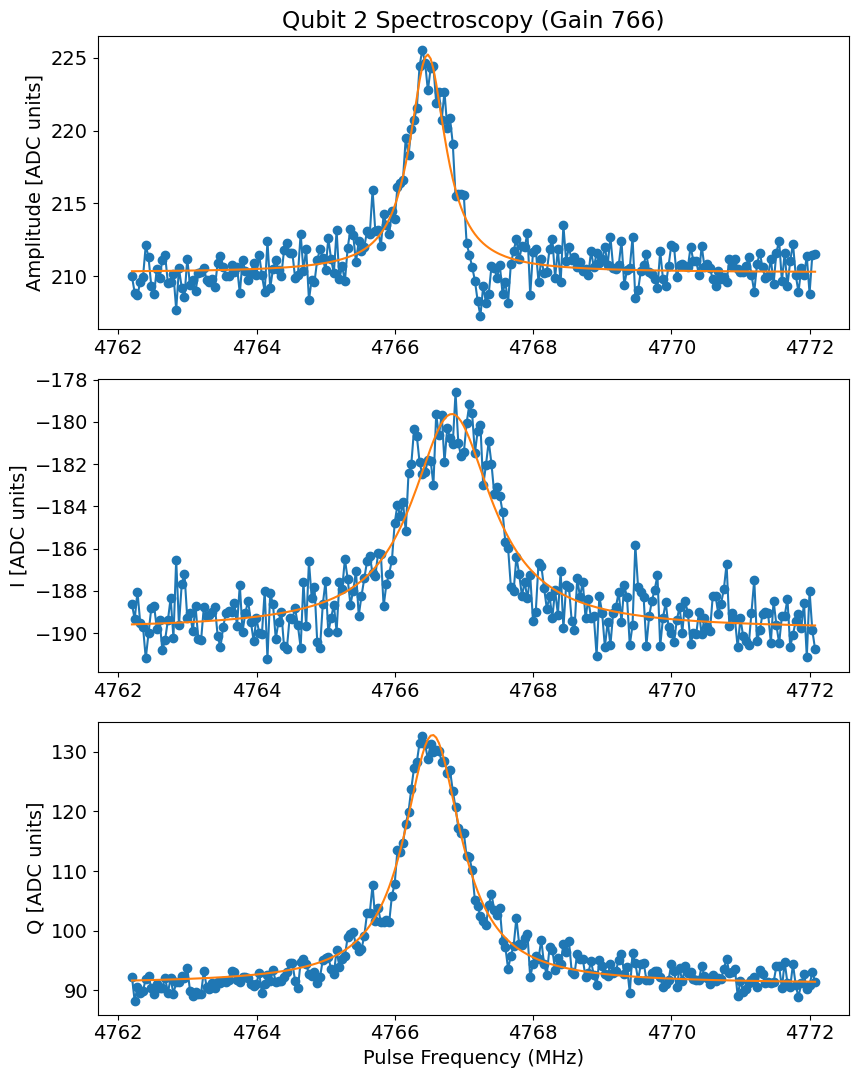

*Set qubit 2 f_ge to 4766.545057647505*
{'Single shot g-e fidelity (%)': 33.627787592919766, 'Qubit freq': 4766.545057647505}


In [22]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(results_Qi)

In [162]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00000_qubit_spectroscopy_qubit3.h5


## Length Rabi

In [310]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=2000,
    gain=yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i], # qubit gain [DAC units],
    # gain=32000, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
# lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.3462371134460894
Pi length from avgi data [us]: 0.014123843452836305
	Pi/2 length from avgi data [us]: 0.007061921726418153

Decay from avgq [us] 0.38307336340886955
Pi length from avgq data [us]: 0.014187267548274976
Pi/2 length from avgq data [us]: 0.007093633774137488


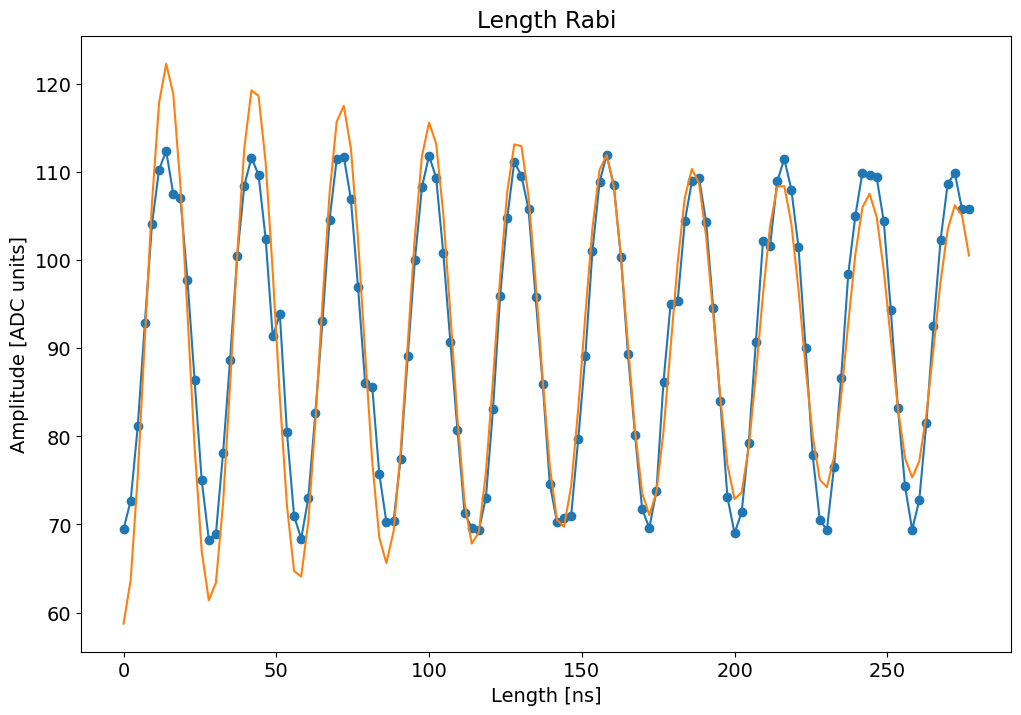

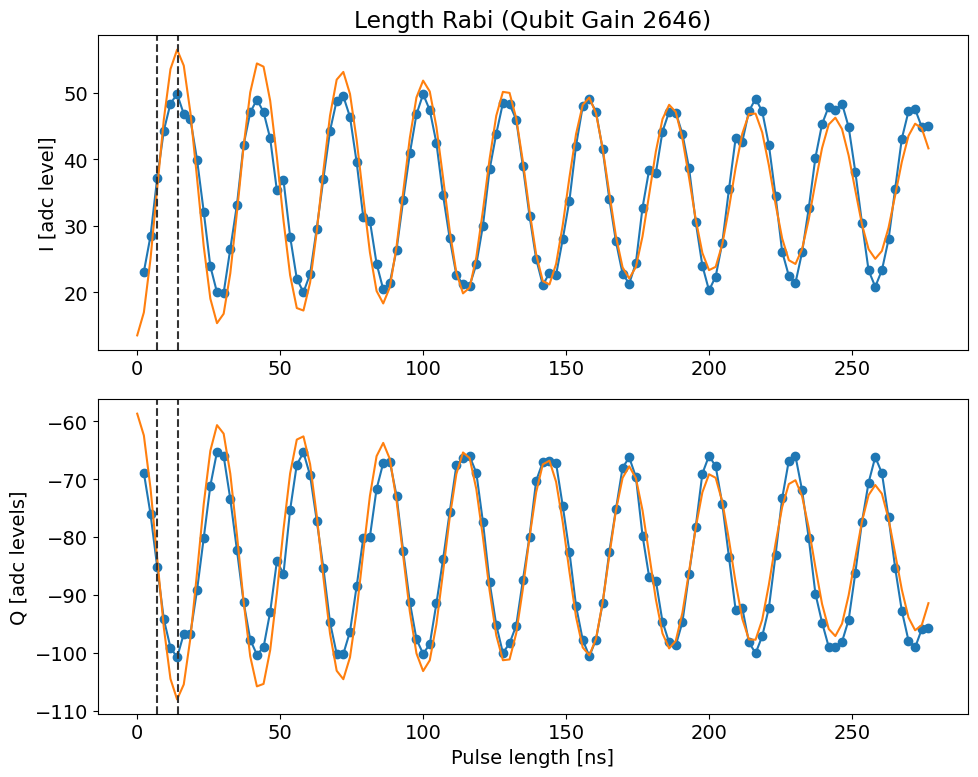

Will use sigma 0.015 for amplitude rabi


In [311]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

lengthrabi.display(fit=True)
p = lengthrabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
else: pi_len = (3/2 - p[2]/180)/2/p[1]
pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

lengthrabi_decay = p[3]

print(f'Will use sigma {pi_len} for amplitude rabi')

In [312]:
if save_data: saved_files.append(lengthrabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00000_length_rabi_qubit3.h5


## Amplitude Rabi

In [70]:
pi_len = yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]
print('qubit', qubit_i, 'pi_len', pi_len)
# pi_len = 0.010

qubit 2 pi_len 0.01


In [71]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i])))
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 9578
	Pi/2 gain from amps data [dac units]: 4789
Pi gain from avgi data [dac units]: 10611
	Pi/2 gain from avgi data [dac units]: 5305
Pi gain from avgq data [dac units]: 11337
	Pi/2 gain from avgq data [dac units]: 5668


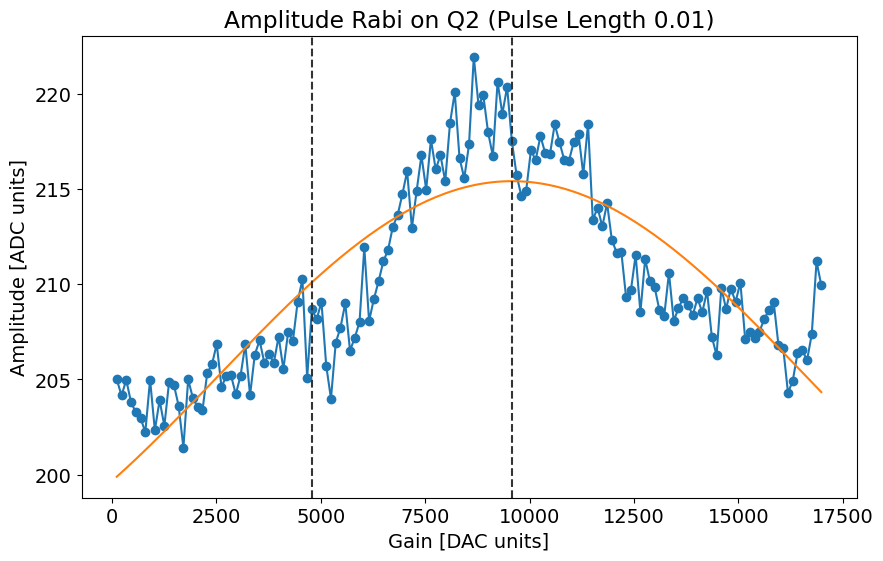

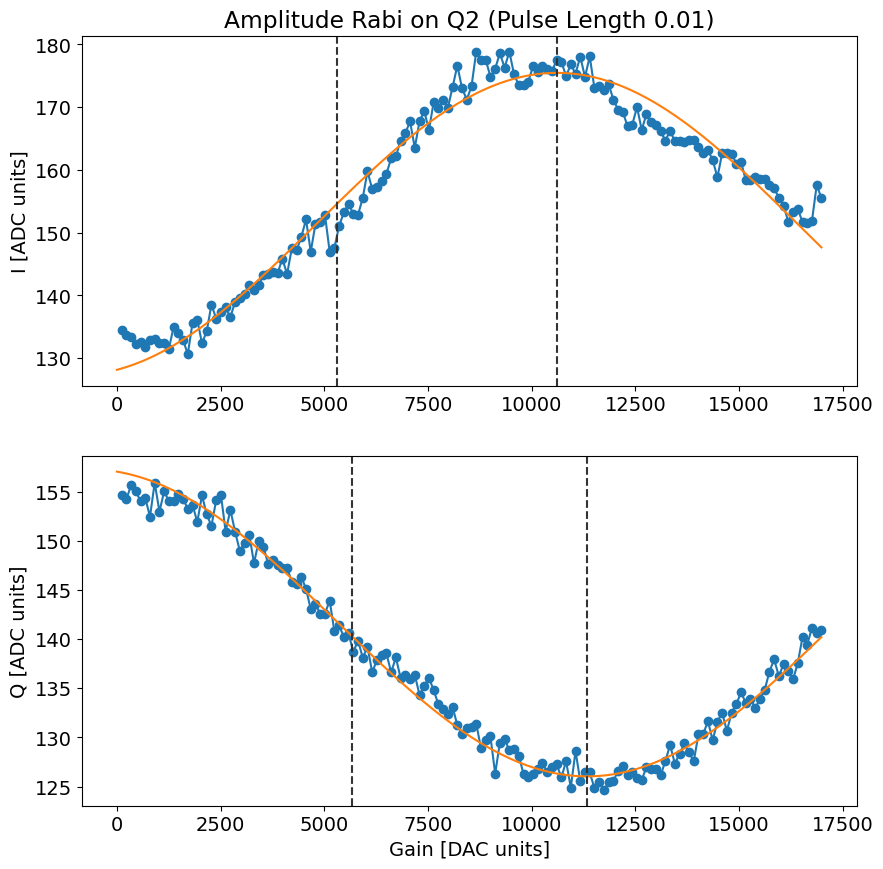

*Set pi pulse sigma for qubit 2 to 0.01*
*Set pi pulse gain for qubit 2 to 11337*
{'Single shot g-e fidelity (%)': 33.627787592919766, 'Qubit freq': 4767.150309998321, 'Res kappa': 0.2, 'T2R': 15.590122767857144, 'T2R err': 2.4384901576109432, 'T1': 53.71750322651323, 'T1 err': 1.1881634664084477, 'Pi pulse len': 0.01, 'Pi pulse gain': 11337}


In [72]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(results_Qi)

In [291]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00002_amp_rabi_qubit2.h5


## $T_1$

In [47]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [68]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 400
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Fit T1 avgi [us]: 27.483444375463495
Fit T1 avgq [us]: 53.71750322651323


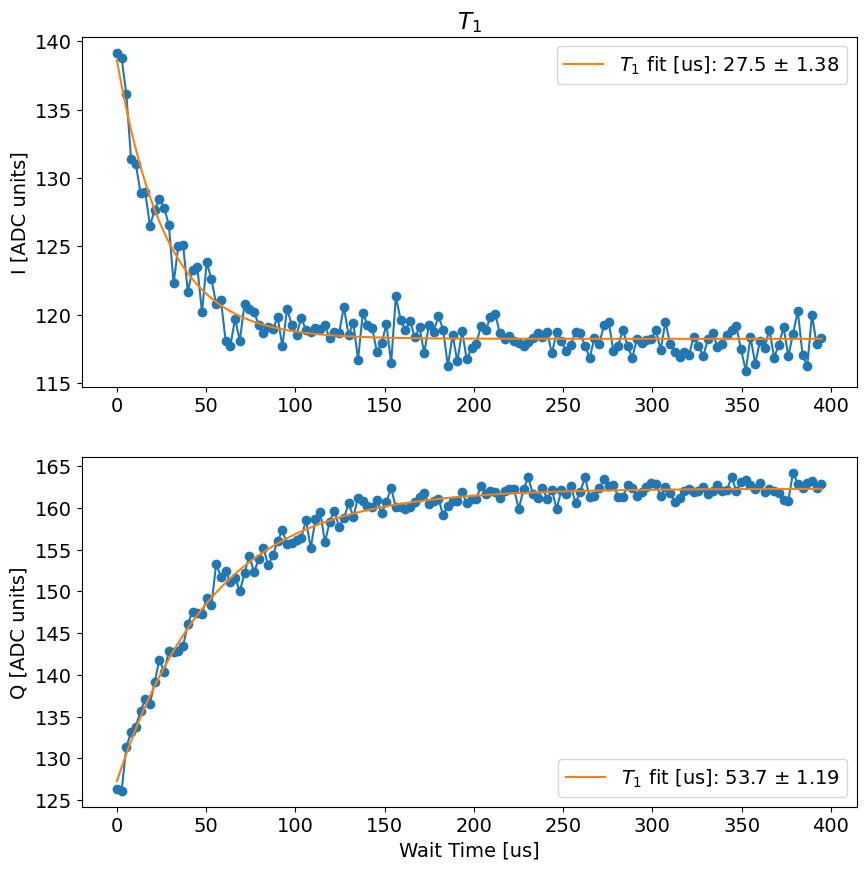

*Set qubit 2 T1 to 54.0*
*Set readout 2 relax delay to 215.0*
{'Single shot g-e fidelity (%)': 33.627787592919766, 'Qubit freq': 4767.150309998321, 'Res kappa': 0.2, 'T2R': 15.590122767857144, 'T2R err': 2.4384901576109432, 'T1': 53.71750322651323, 'T1 err': 1.1881634664084477}


In [69]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(4*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(results_Qi)

In [19]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00003_t1_qubit2.h5


## $T_2$ Ramsey round 1

In [82]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [83]:
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

Ramsey freq [MHz]: 2.0


In [84]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(1) if short_T1 else soc.cycles2us(8), # [us] 
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=200,
    # expts=500,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    # reps=5,
    rounds=20,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/20 [00:00<?, ?it/s]

Current pi pulse frequency: 4767.148398674606
Fit frequency from amps [MHz]: 2.027791125446497 +/- 0.011483114582302532
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4767.12060754916
 	4763.12060754916
T2 Ramsey from fit amps [us]: 1.3811383963158126
Current pi pulse frequency: 4767.148398674606
Fit frequency from I [MHz]: 2.122467275746502 +/- 0.023851783831200454
Suggested new pi pulse frequency from fit I [MHz]:
 	4767.02593139886
 	4763.02593139886
Beating frequency from fit I [MHz]:
 	4769.107993643814
 	4764.048398722873
T2 Ramsey from fit I [us]: 1.3811383931303816
Fit frequency from Q [MHz]: 2.002723034853179 +/- 0.0030237876839649494
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4767.145675639753
 	4763.145675639753
Beating frequency from fit Q [MHz]:
 	4769.106314277018
 	4764.248397231413
T2 Ramsey from fit Q [us]: 2.514578391863746


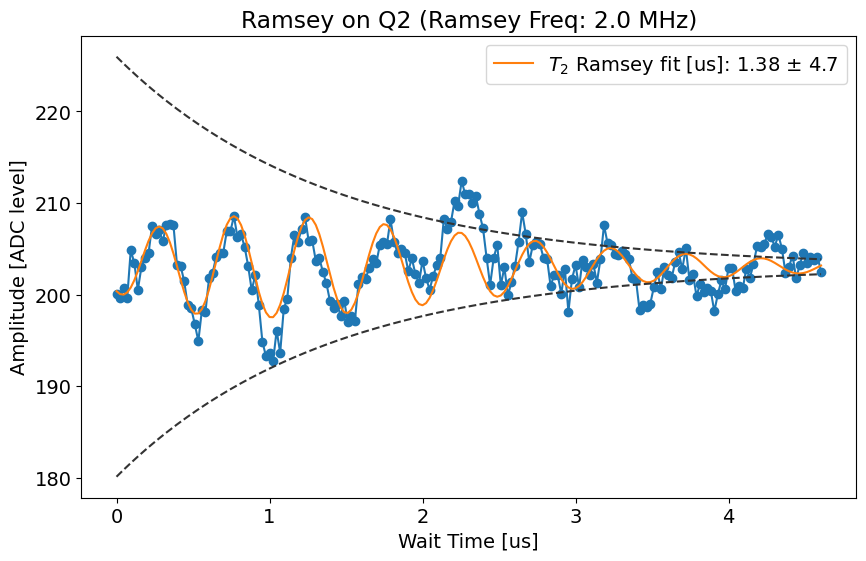

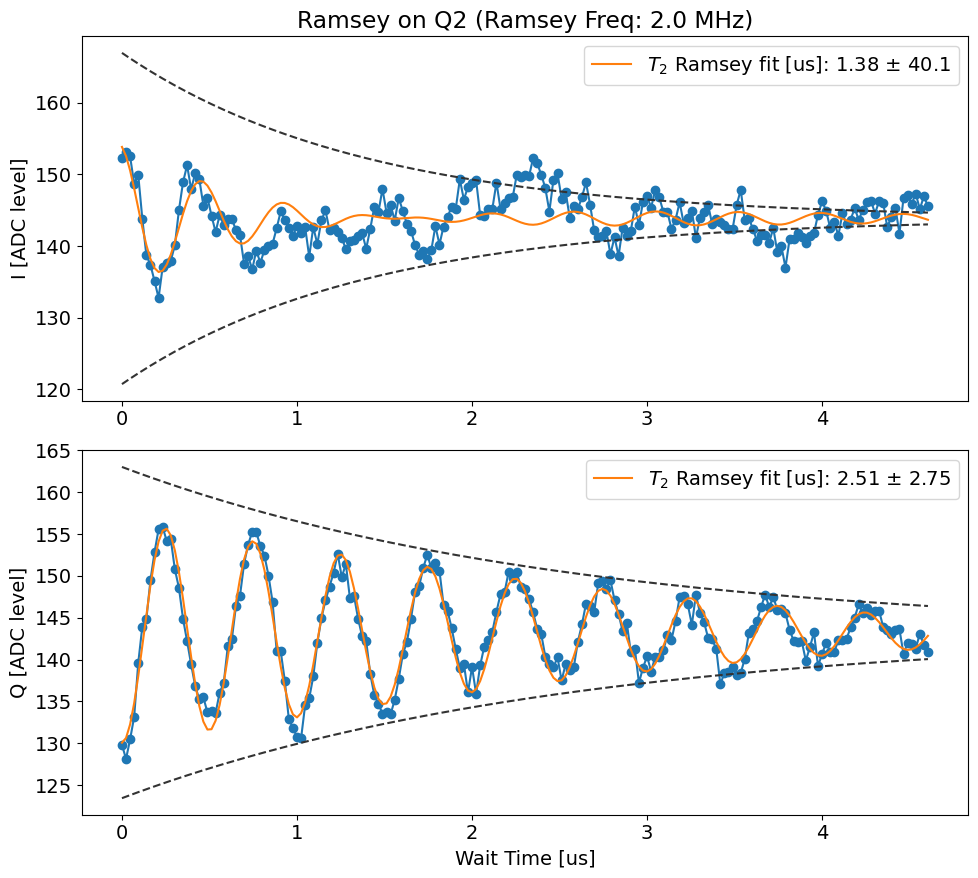

In [86]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)

t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge[qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

# t2r.analyze(fit=True, fit_twofreq=True)
# t2r.display(fit=True, fit_twofreq=True)

In [20]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00002_ramsey_qubit2.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [88]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(2) if t2r_fit[3] < 3 else soc.cycles2us(60), # [us]
    # step=soc.cycles2us(80), # [us]
    step=soc.cycles2us(150), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/15, # [MHz]
    # ramsey_freq=ramsey_freq/20, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    checkZZ=False,
    checkEF=False,
    qubits=[qubit_i],
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 4767.148398674606
Fit frequency from amps [MHz]: 0.12315703488761896 +/- 0.002278239647182112
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4767.158574973052
 	4766.891908306386
T2 Ramsey from fit amps [us]: 15.590122767857144
Current pi pulse frequency: 4767.148398674606
Fit frequency from I [MHz]: 0.07300526843477018 +/- 0.002211816548200861
Suggested new pi pulse frequency from fit I [MHz]:
 	4767.2087267395045
 	4766.942060072838
T2 Ramsey from fit I [us]: 15.590122767857144
Fit frequency from Q [MHz]: 0.0899066941676855 +/- 0.0014693343309727166
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4767.191825313772
 	4766.9251586471055
T2 Ramsey from fit Q [us]: 15.590122767857144


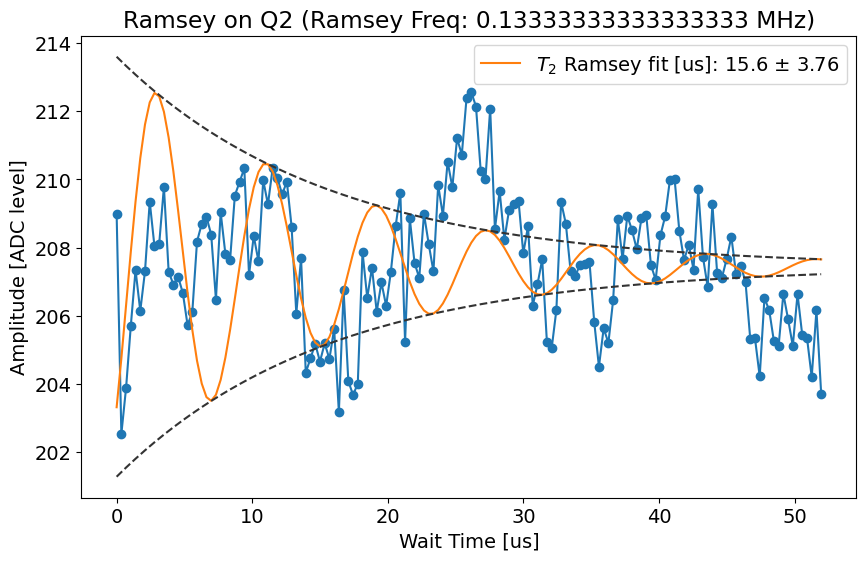

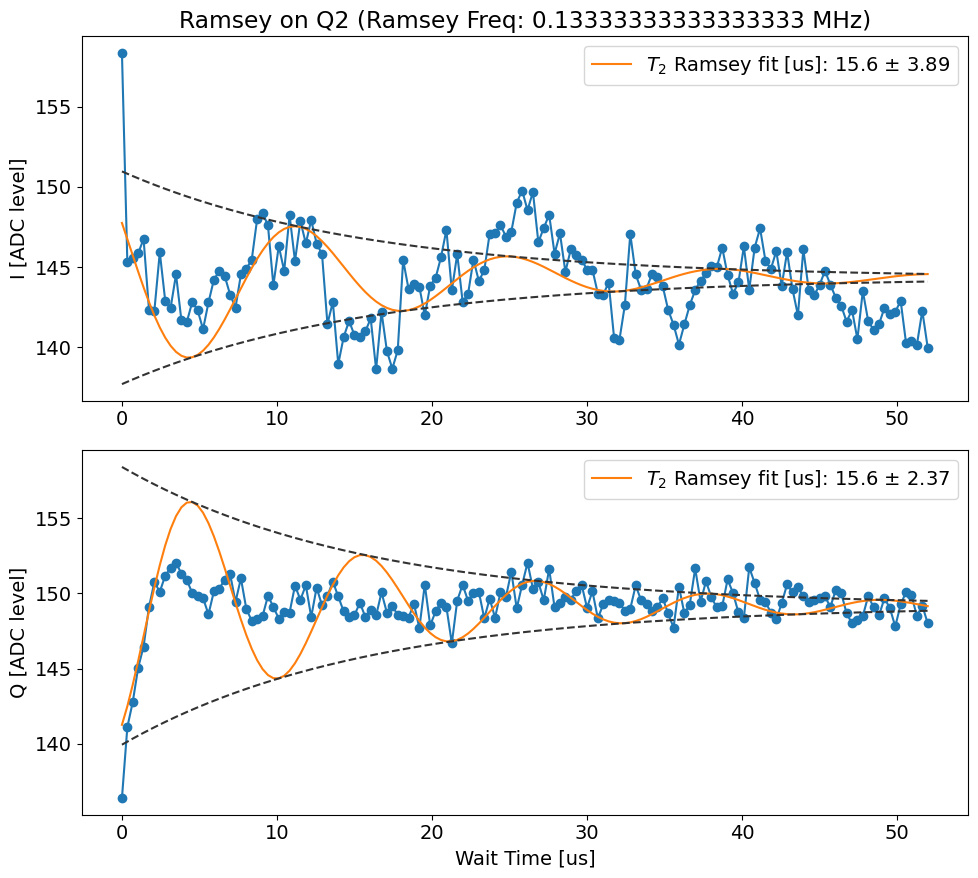

*Set qubit 2 freq to 4767.191825313772*
{'Single shot g-e fidelity (%)': 33.627787592919766, 'Qubit freq': 4767.191825313772, 'Res kappa': 0.2, 'T2R': 15.590122767857144, 'T2R err': 2.371706341142622, 'T1': 53.71750322651323, 'T1 err': 1.1881634664084477, 'Pi pulse len': 0.01, 'Pi pulse gain': 11337, 'T2E': 27.72815029209444, 'T2E err': 1.419511295236395}
Redo T2R: False


In [89]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge[qubit_i] + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= ramsey_freq/10:
# if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [169]:
if save_data: saved_files.append(t2r_2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00001_ramsey_qubit3.h5


## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [328]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        checkZZ=False,
        checkEF=False,
        qubits=[qubit_i],
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [329]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [330]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [ ]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
# short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [ ]:
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

Ramsey freq [MHz]: 2.0


In [77]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    # step=soc.cycles2us(80), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    step=soc.cycles2us(3) if short_T1 else soc.cycles2us(150), # [us] 
    expts=151,
    ramsey_freq=max((ramsey_freq/20, 0.100)), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=20,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Current qubit frequency: 4767.148993712071
Fit frequency from I [MHz]: 0.10088493687317432 +/- 0.0018891059217456883
T2 Echo from fit I [us]: 15.590122767857144
Fit frequency from Q [MHz]: 0.09951813643062679 +/- 0.0003052336488550259
T2 Echo from fit Q [us]: 27.72815029209444


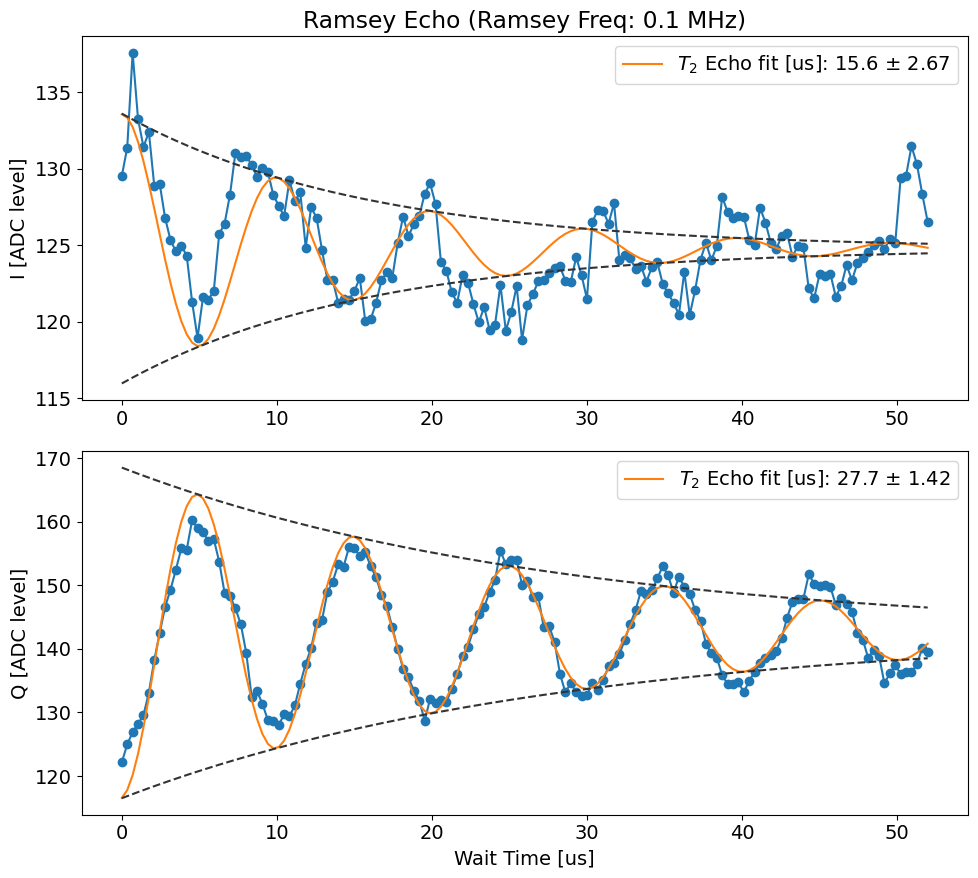

{'Single shot g-e fidelity (%)': 33.627787592919766, 'Qubit freq': 4767.150309998321, 'Res kappa': 0.2, 'T2R': 15.590122767857144, 'T2R err': 2.4384901576109432, 'T1': 53.71750322651323, 'T1 err': 1.1881634664084477, 'Pi pulse len': 0.01, 'Pi pulse gain': 11337, 'T2E': 27.72815029209444, 'T2E err': 1.419511295236395}


In [78]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(results_Qi)
# print('Results updated.')

In [333]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00000_echo_qubit3.h5


# Resonator chi shift (g/e)

In [334]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[93.14577703860928, 5000, 1000, 0, 43.18318534108863, 114.42188031709959, -0.6853742719040049]
5925.0
950
93.14577703860928

Freq with minimum transmission: 92.38418763463577
Freq with maximum transmission: 90.86100882668875
From fit:
	f0: 6968.14577703861
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: 8.361774932446332
	phi [radians]: 0


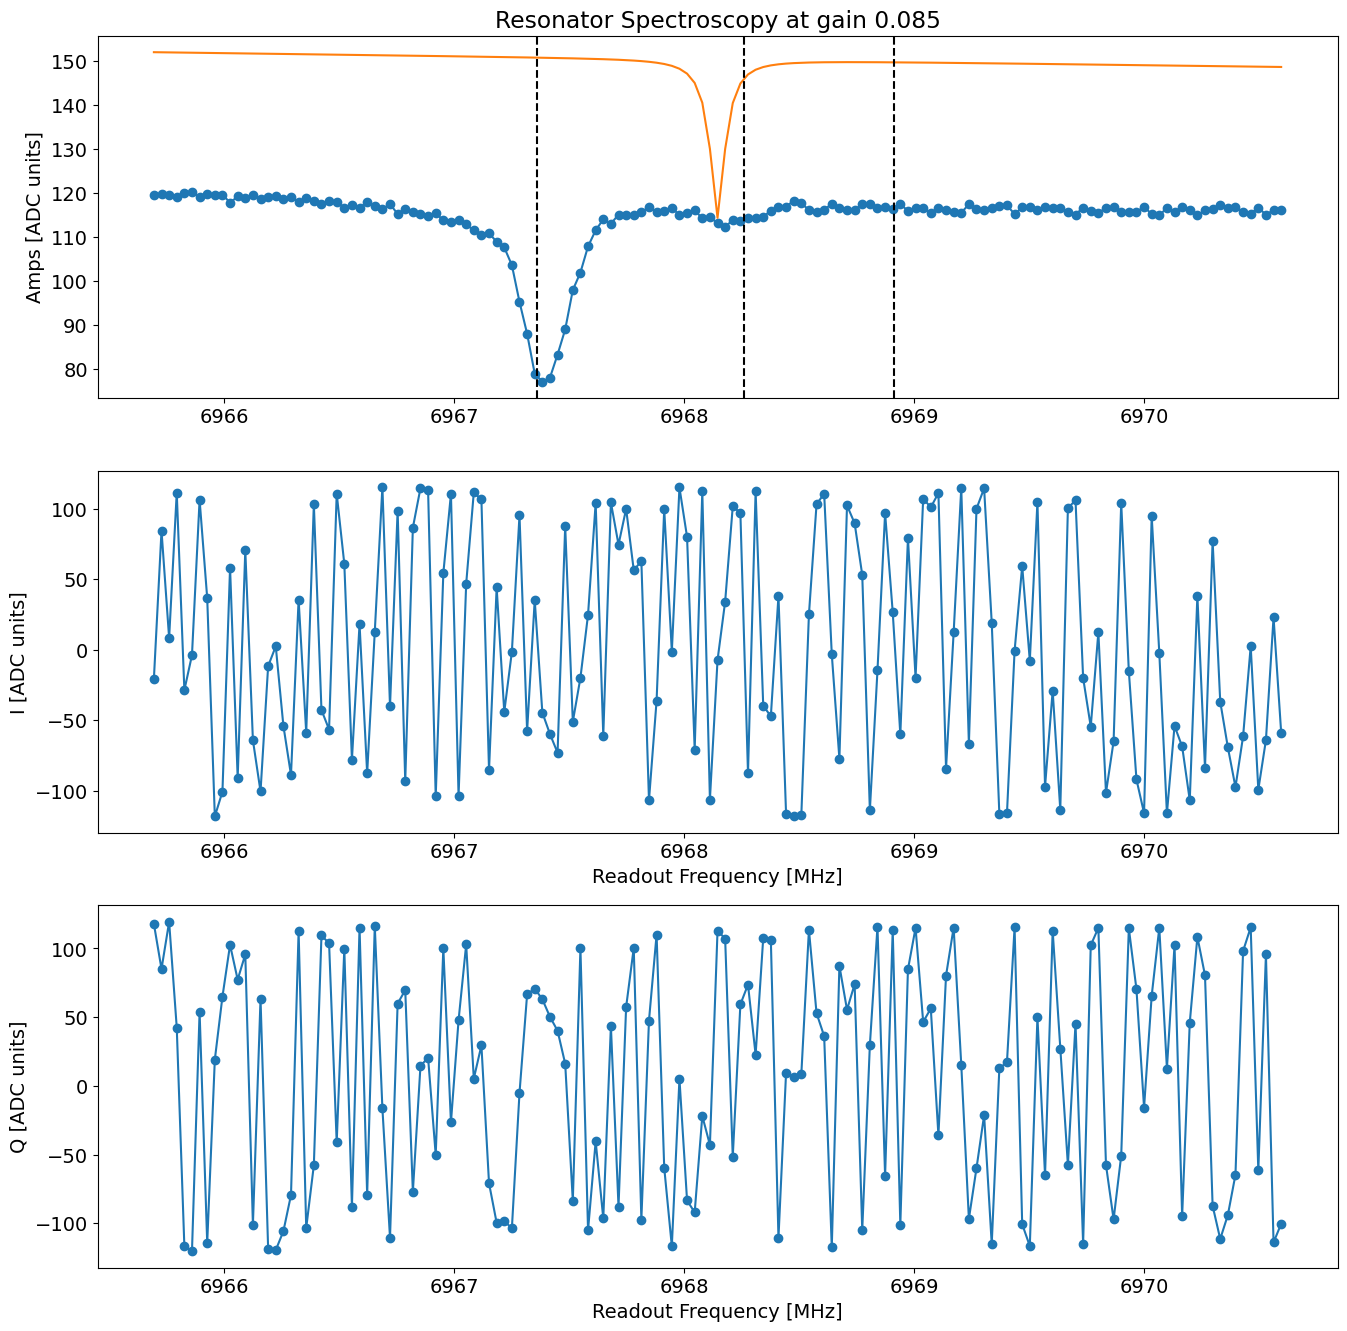

Res freq e 92.38418763463577
Res freq g 93.16233333000001
[{'Single shot g-e fidelity (%)': 41.78805960198673}, {'Qubit freq': 3450.7895590725893, 'Pi pulse len': 0.1, 'Pi pulse gain': 24945, 'T1': 88.01528902085553, 'T1 err': 2.3898312185719965, 'T2R': 44.15111045498067, 'T2R err': 1.962086656050886, 'T2E': 30.25929694612411, 'T2E err': 1.7462673977469687, 'Qubit EF freq': 3350.330233073566, 'EF pi pulse len': 0.04686378155276164, 'EF pi pulse gain': 29107, 'Qubit temp [mK]': 56.199674644449665, 'Single shot g-e fidelity (%)': 49.214973832461084}, {'Qubit freq': 4767.359704214145, 'Pi pulse len': 0.020886833661091352, 'Pi pulse gain': 2705, 'T1': 32.93056755583473, 'T1 err': 1.2325694970800454, 'T2R': 12.882410694681475, 'T2R err': 1.4701638837441797, 'T2E': 17.77399784383835, 'T2E err': 0.9103708488638977, 'Res chi shift (e - g)': 1.6390728476820868, 'Qubit EF freq': 4577.689960511519, 'EF pi pulse len': 0.022312951557475664, 'EF pi pulse gain': 1859, 'Qubit temp [mK]': 80.9485504562

In [368]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = rspec_chi.data['xpts'][np.argmax(rspec_chi.data['amps'])]
print('Res freq e', res_freq_e)
print('Res freq g', yaml_cfg.device.readout.frequency[qubit_i])
# res_freq_e = -83
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [336]:
if save_data: saved_files.append(rspec_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00000_resonator_spectroscopy_chi_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [63]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/50), # ef pulse gain
    # gain=5000,
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4576.806486388101, HWHM 1.7065909147965896
Found peak in I at [MHz] 4577.310838156333, HWHM 2.112610606967808
Found peak in Q at [MHz] 4576.8928336501185, HWHM 1.912778742664066


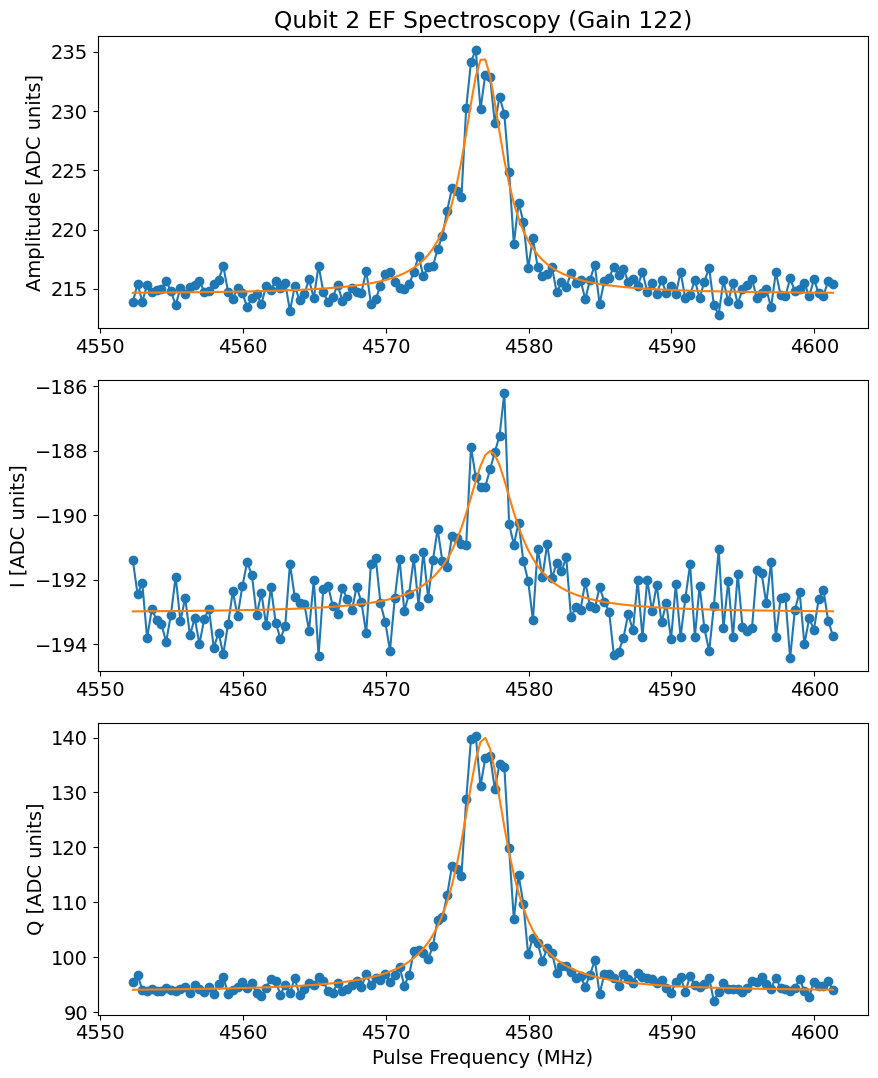

*Set qubit 2 f_ef to 4576.8928336501185*
[{}, {}, {'Pi pulse len': 0.01, 'Pi pulse gain': 11495, 'Qubit EF freq': 4576.8928336501185, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 6131, 'T2R': 17.962892177794192, 'T2R err': 0.6613368092795688, 'Qubit freq': 4766.830916901354}, {'Pi pulse len': 0.01, 'Pi pulse gain': 3846, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 2117, 'Qubit EF freq': 4213.347686031533}]


In [64]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [339]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00000_qubit_EF_spectroscopy_qubit3.h5


## Pulse Probe EF spectroscopy round 2

In [241]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/100), # ef pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3354.61622879779, HWHM 1.3635538969426488
Found peak in I at [MHz] 3354.626046431369, HWHM 1.329240201342907
Found peak in Q at [MHz] 3354.578291908747, HWHM 1.496096523755771


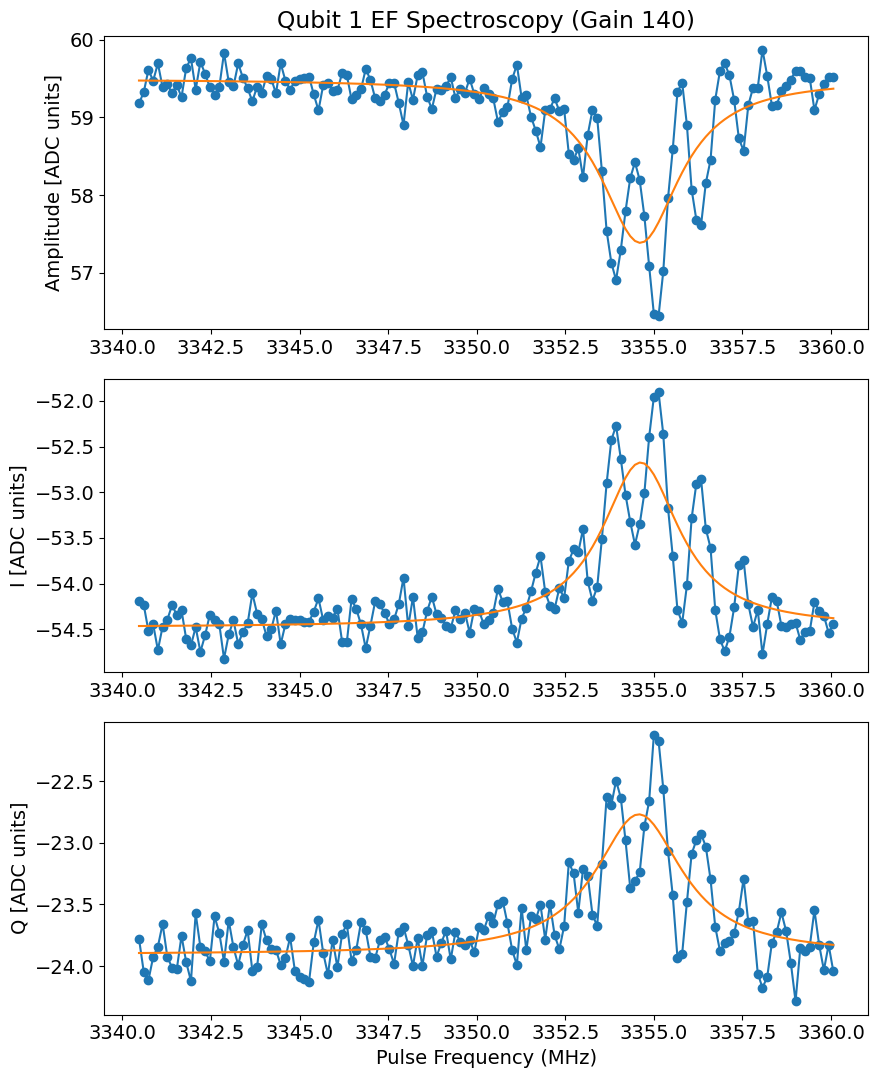

*Set qubit 1 f_ef to 3354.61622879779*
[{'Qubit freq': 4115.6290596912495, 'Pi pulse len': 0.015, 'Pi pulse gain': 28082, 'T1': 47.577103705219685, 'T1 err': 2.3962277160977354, 'T2R': 14.111163885694353, 'T2R err': 0.7373776043830153, 'Single shot g-e fidelity (%)': 36.19574638309221}, {'Pi pulse len': 0.01, 'Pi pulse gain': 16422, 'T1': 89.2251513100458, 'T1 err': 4.052995776697742, 'T2R': 17.228011399745398, 'T2R err': 1.5353717912209561, 'Qubit freq': 3452.4653657086023, 'Single shot g-e fidelity (%)': 34.34114470482349, 'Qubit EF freq': 3354.61622879779}, {'Qubit freq': 4766.8208180553465, 'T2R': 11.820686410910842, 'T2R err': 0.642625549774108, 'Pi pulse len': 0.006, 'Pi pulse gain': 11072, 'T1': 42.01005418874927, 'T1 err': 1.205895286020466, 'Qubit EF freq': 4577.0649811867825, 'EF pi pulse len': 0.006, 'EF pi pulse gain': 8276, 'Single shot g-e fidelity (%)': 52.548418280609354}, {'Qubit freq': 4386.208444751211, 'T2R': 26.43172216798599, 'T2R err': 1.24969888834873, 'Pi pulse

In [242]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [243]:
if save_data: saved_files.append(qEFspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00000_qubit_EF_spectroscopy_qubit1.h5


## Length EF Rabi

In [343]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(3), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i], # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.3764922419946439
Pi length from avgi data [us]: 0.015392026319754951
	Pi/2 length from avgi data [us]: 0.007696013159877476

Decay from avgq [us] 0.3427216250782644
Pi length from avgq data [us]: 0.015357225105323589
Pi/2 length from avgq data [us]: 0.007678612552661794


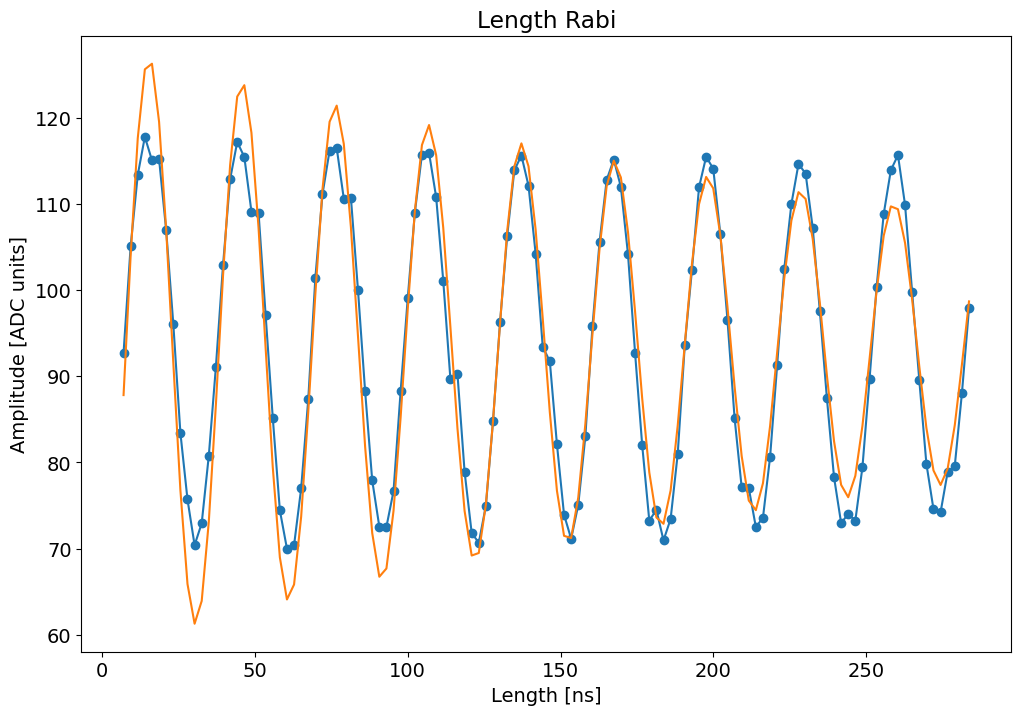

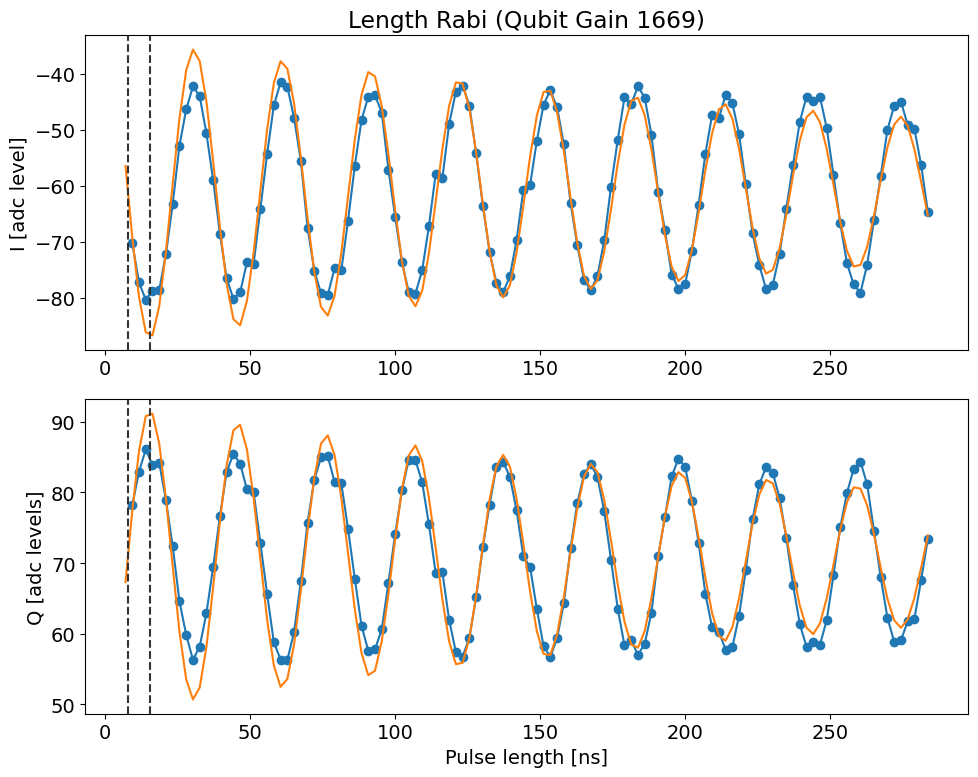

Will use sigma 0.015 for amplitude rabi EF


In [344]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True)

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True)
p = lengthrabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

lengthrabiEF_decay = p[3]

print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [345]:
if save_data: saved_files.append(lengthrabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00000_length_rabiEF_qubit3.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [44]:
pi_lenEF = yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]
# pi_lenEF = 0.045
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

qubit 3 pi_lenEF 0.012


In [45]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=20,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 2072
	Pi/2 gain from amps data [dac units]: 1036
Pi gain from avgi data [dac units]: 2117
	Pi/2 gain from avgi data [dac units]: 1058
Pi gain from avgq data [dac units]: 2099
	Pi/2 gain from avgq data [dac units]: 1049


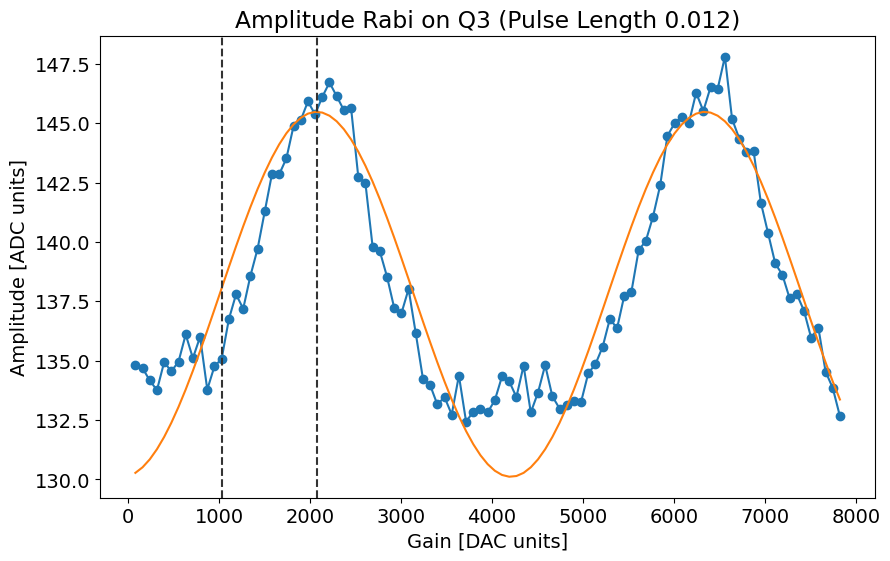

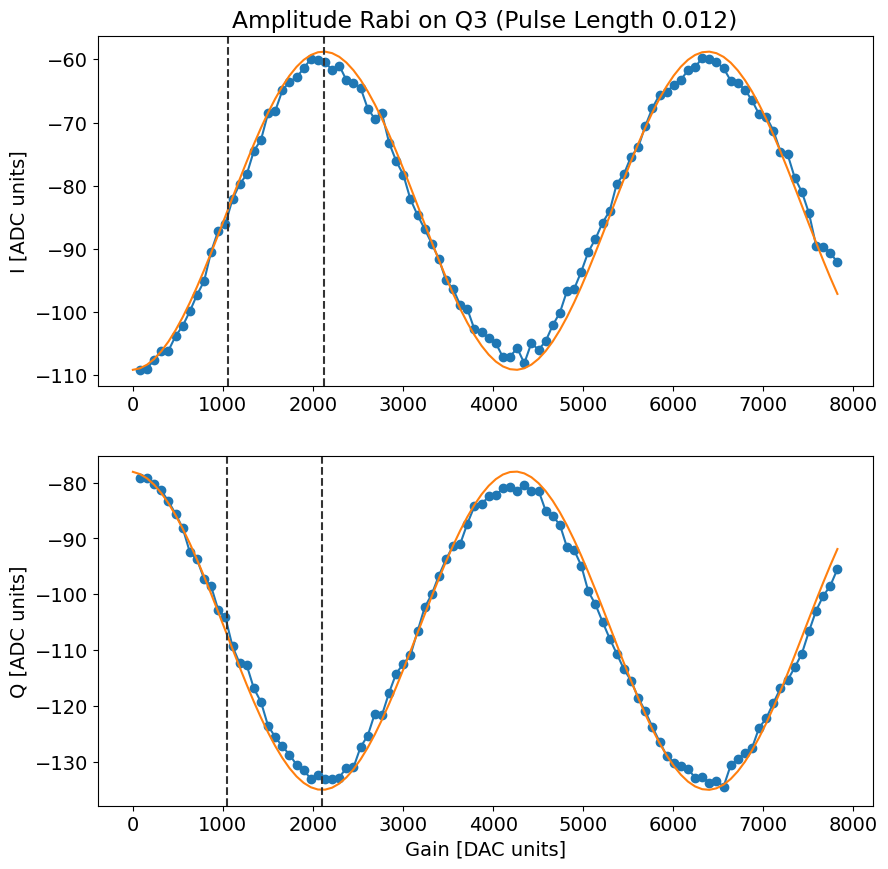

*Set EF pi pulse sigma for qubit 3 to 0.012*
*Set EF pi pulse gain for qubit 3 to 2117*
[{}, {}, {'Pi pulse len': 0.01, 'Pi pulse gain': 11495, 'Qubit EF freq': 4576.9686517467035, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 6131}, {'Pi pulse len': 0.01, 'Pi pulse gain': 3846, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 2117}]


In [46]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [47]:
if save_data: saved_files.append(amprabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00002_amp_rabi_EF_qubit3.h5


## Qubit temperature

In [349]:
amprabiEF2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF2.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, 1.25*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
npts = 101

amprabiEF2.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=60,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF2.cfg)
amprabiEF2.go(analyze=False, display=False, progress=True, save=False)

gauss


  0%|          | 0/60 [00:00<?, ?it/s]

yscale normal: 42.98905144299549
yscale no pulse: 2.2999112982628276
Pi gain from amps data [dac units]: 1979
	Pi/2 gain from amps data [dac units]: 989
Pi gain from avgi data [dac units]: 1967
	Pi/2 gain from avgi data [dac units]: 983
Pi gain from avgq data [dac units]: 2051
	Pi/2 gain from avgq data [dac units]: 1025


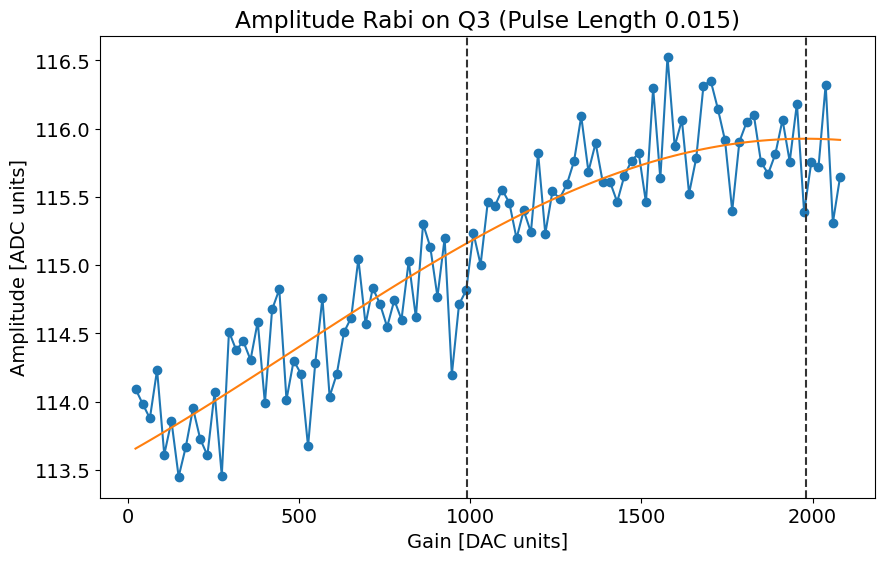

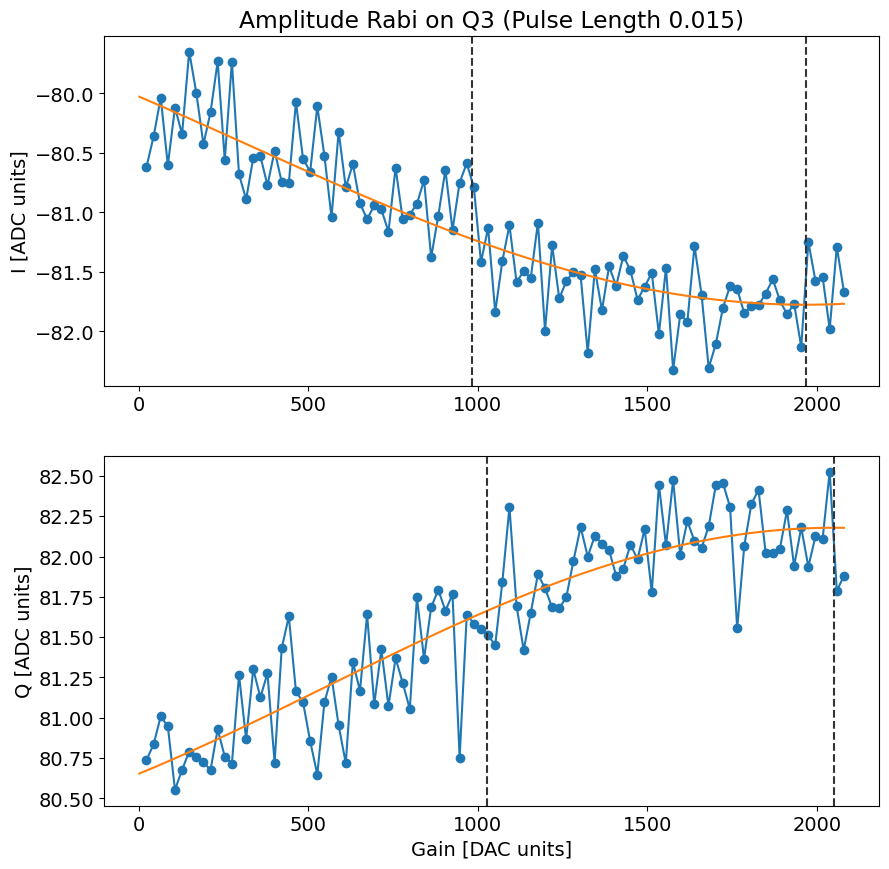

Qubit temp [mK]: 71.8915969717869
[{'Single shot g-e fidelity (%)': 41.78805960198673}, {'Qubit freq': 3450.7895590725893, 'Pi pulse len': 0.1, 'Pi pulse gain': 24945, 'T1': 88.01528902085553, 'T1 err': 2.3898312185719965, 'T2R': 44.15111045498067, 'T2R err': 1.962086656050886, 'T2E': 30.25929694612411, 'T2E err': 1.7462673977469687, 'Qubit EF freq': 3350.330233073566, 'EF pi pulse len': 0.04686378155276164, 'EF pi pulse gain': 29107, 'Qubit temp [mK]': 56.199674644449665, 'Single shot g-e fidelity (%)': 49.214973832461084}, {'Qubit freq': 4767.359704214145, 'Pi pulse len': 0.020886833661091352, 'Pi pulse gain': 2705, 'T1': 32.93056755583473, 'T1 err': 1.2325694970800454, 'T2R': 12.882410694681475, 'T2R err': 1.4701638837441797, 'T2E': 17.77399784383835, 'T2E err': 0.9103708488638977, 'Res chi shift (e - g)': 1.6390728476820868, 'Qubit EF freq': 4577.689960511519, 'EF pi pulse len': 0.022312951557475664, 'EF pi pulse gain': 1859, 'Qubit temp [mK]': 80.94855045625054, 'Single shot g-e f

In [350]:
# TESTING
# amprabiEF2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF2.data = temp_data

# amprabiEF2.analyze(fit=False)
# amprabiEF2.display(fit=False)

amprabiEF2.analyze(fit=True)

amprabiEF2_fit, amprabiEF2_fit_err = meas.fitting.get_best_fit(amprabiEF2.data)

# NATURAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF2.cfg.device.qubit.f_ge[qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

amprabiEF_amps = amprabiEF.data['amps']
p = amprabiEF.data['fit_amps']
# efamp_normal = p[0]
efamp_normal = max(amprabiEF.data['amps']) - min(amprabiEF.data['amps'])

amprabiEF2_amps = amprabiEF2.data['amps']
p = amprabiEF2.data['fit_amps']
fit_vals = meas.fitting.sinfunc(amprabiEF.data['xpts'], *p)
efamp_nopulse = max(fit_vals) - min(fit_vals)

print('yscale normal:', efamp_normal)
print('yscale no pulse:', efamp_nopulse)

temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal))

amprabiEF2.display(fit=True)

print('Qubit temp [mK]:', temp)
results_Qi.update({'Qubit temp [mK]':temp})
print(all_results)

In [351]:
if save_data: saved_files.append(amprabiEF2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00001_amp_rabi_EF_qubit3.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [48]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubitEF_hwhm = 2
# short_T1 = False

In [49]:
ramseyEF_freq = max((min((np.abs(np.ceil(qubitEF_hwhm)), 3)), 2))

t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 4213.264346730453
Fit frequency from amps [MHz]: 1.9149245060986322 +/- 0.008313406832657147
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4213.349422224354
 	4209.349422224354
T2 Ramsey from fit amps [us]: 2.5488682456498233
Current pi pulse frequency: 4213.264346730453
Fit frequency from I [MHz]: 1.9225391162023342 +/- 0.003122473354231636
Suggested new pi pulse frequency from fit I [MHz]:
 	4213.341807614251
 	4209.341807614251
T2 Ramsey from fit I [us]: 3.592758744041352
Fit frequency from Q [MHz]: 1.9210068027995546 +/- 0.0033471680255457237
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4213.343339927654
 	4209.343339927654
T2 Ramsey from fit Q [us]: 3.4038892439366855


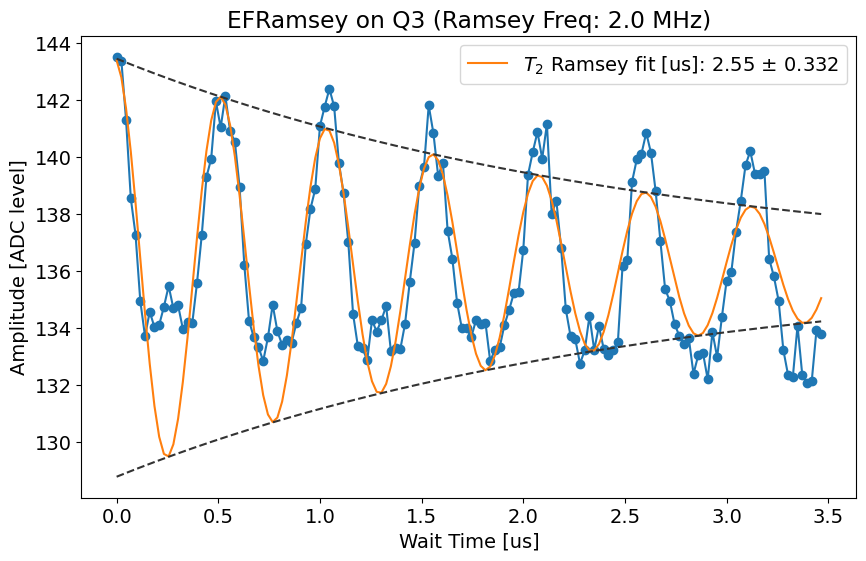

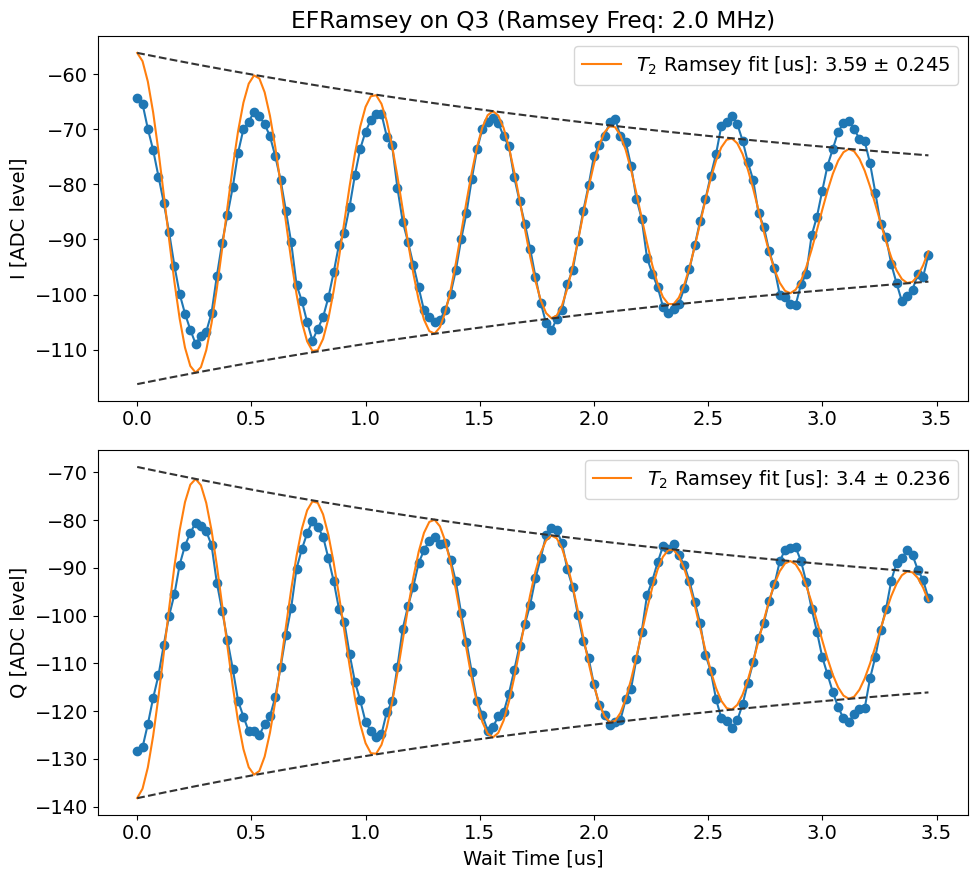

*Set qubit 3 EF freq to 4213.341807614251*
[{}, {}, {'Pi pulse len': 0.01, 'Pi pulse gain': 11495, 'Qubit EF freq': 4576.9686517467035, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 6131}, {'Pi pulse len': 0.01, 'Pi pulse gain': 3846, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 2117, 'Qubit EF freq': 4213.341807614251}]


In [50]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [51]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00001_ramseyEF_qubit3.h5


## EF Ramsey Fringe Round 2
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [52]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubitEF_hwhm = 7
# short_T1 = False

In [53]:
t2EFr_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr_2.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(80), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq/10, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr_2.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 4213.341807614251
Fit frequency from amps [MHz]: 0.2000316263731446 +/- 0.001821969491920255
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4213.341775987878
 	4212.941775987878
T2 Ramsey from fit amps [us]: 10.206177850612734
Current pi pulse frequency: 4213.341807614251
Fit frequency from I [MHz]: 0.1927713905835082 +/- 0.002021719035673226
Suggested new pi pulse frequency from fit I [MHz]:
 	4213.349036223667
 	4212.9490362236675
T2 Ramsey from fit I [us]: 11.186744464088264
Fit frequency from Q [MHz]: 0.1941215827174001 +/- 0.0013468934018642125
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4213.347686031533
 	4212.9476860315335
T2 Ramsey from fit Q [us]: 9.385076694280873


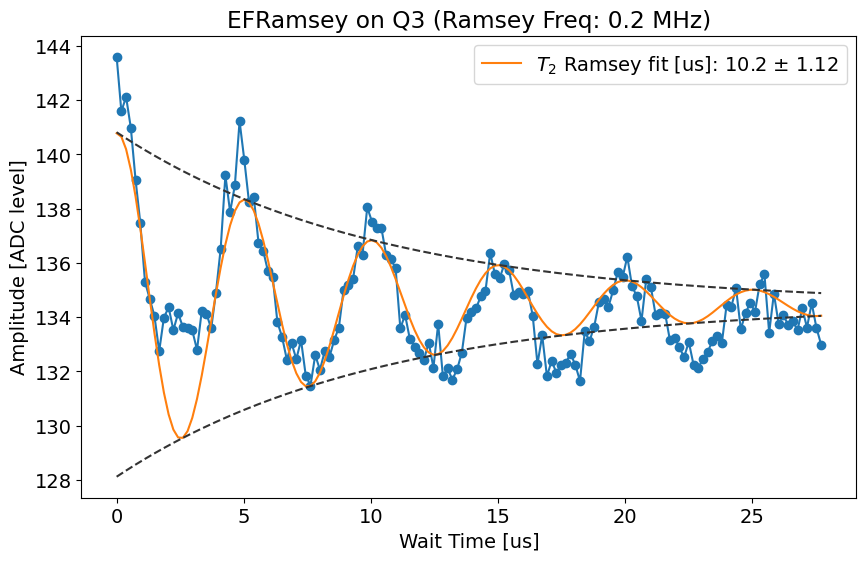

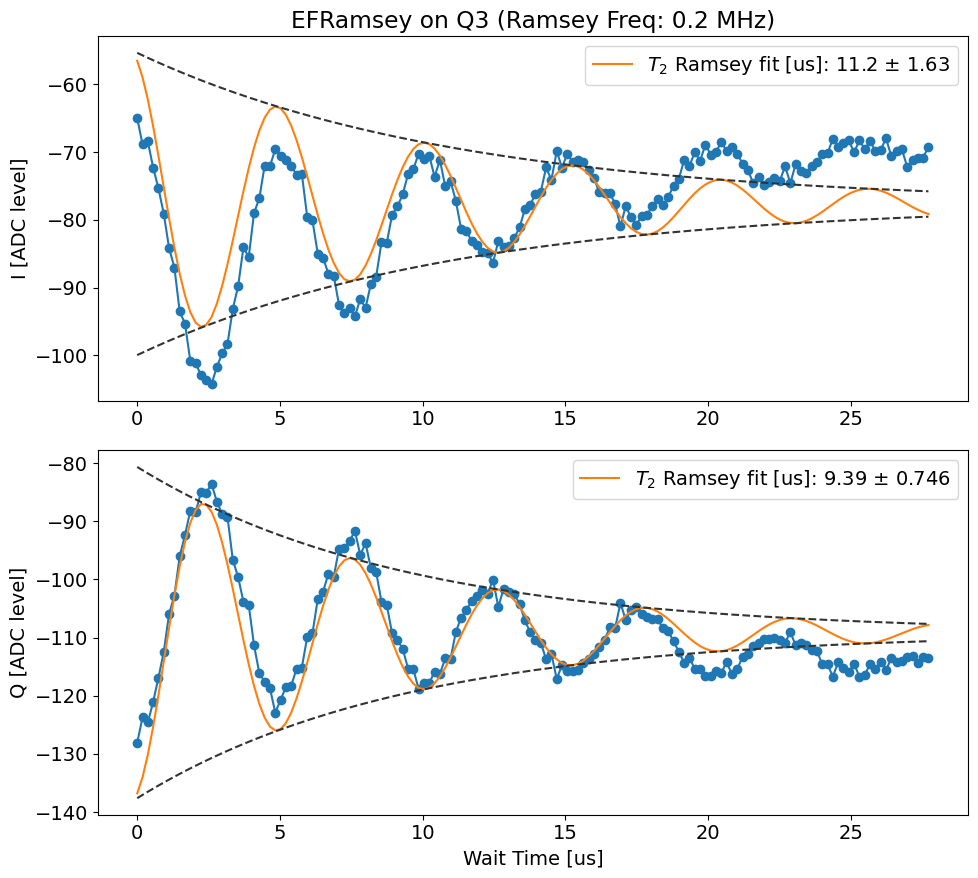

*Set qubit 3 EF freq to 4213.347686031533*
{'Pi pulse len': 0.01, 'Pi pulse gain': 3846, 'EF pi pulse len': 0.012, 'EF pi pulse gain': 2117, 'Qubit EF freq': 4213.347686031533}


In [54]:
# # TESTING
# # t2EFr_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr_2.data = temp_data

t2EFr_2.analyze(fit=True)
t2EFr_2_fit, t2EFr_2_fit_err, t2EFr_2_adjust = meas.fitting.get_best_fit(t2EFr_2.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr_2.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_2_fit, (list, np.ndarray)):
    t2EFr_2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr_2.display(fit=True)

if t2EFr_2_adjust[0] > ramseyEF_freq/10:
    print('WARNING: your EF frequency is not converging!')
else:
    yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_2_adjust[0]
    alt_qubit_freq = old_qubit_freq + t2EFr_2_adjust[1]
    print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
    results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)

In [187]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00000_ramseyEF_qubit3.h5


# Resonator chi shift (e/f)

In [360]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[88.34445253529802, 5000, 1000, 0, 17.90881308138134, 128.4870299118777, -3.14927028877128]
[ 8.84455942e+01  2.18252489e+03  4.26021028e+04 -1.25095649e+00
  5.31733600e+01  1.25567845e+02 -3.36161110e+00]
5925.0
950
88.44559421600414

Freq with minimum transmission: 90.76167107834438
Freq with maximum transmission: 86.05968432337748
From fit:
	f0: 6963.445594216004
	Qi: 2182.524893751444
	Qe: 42602.10281203844
	Q0: 2076.1621716330924
	kappa [MHz]: 3.353998878006054
	phi [radians]: -1.2509564861989797


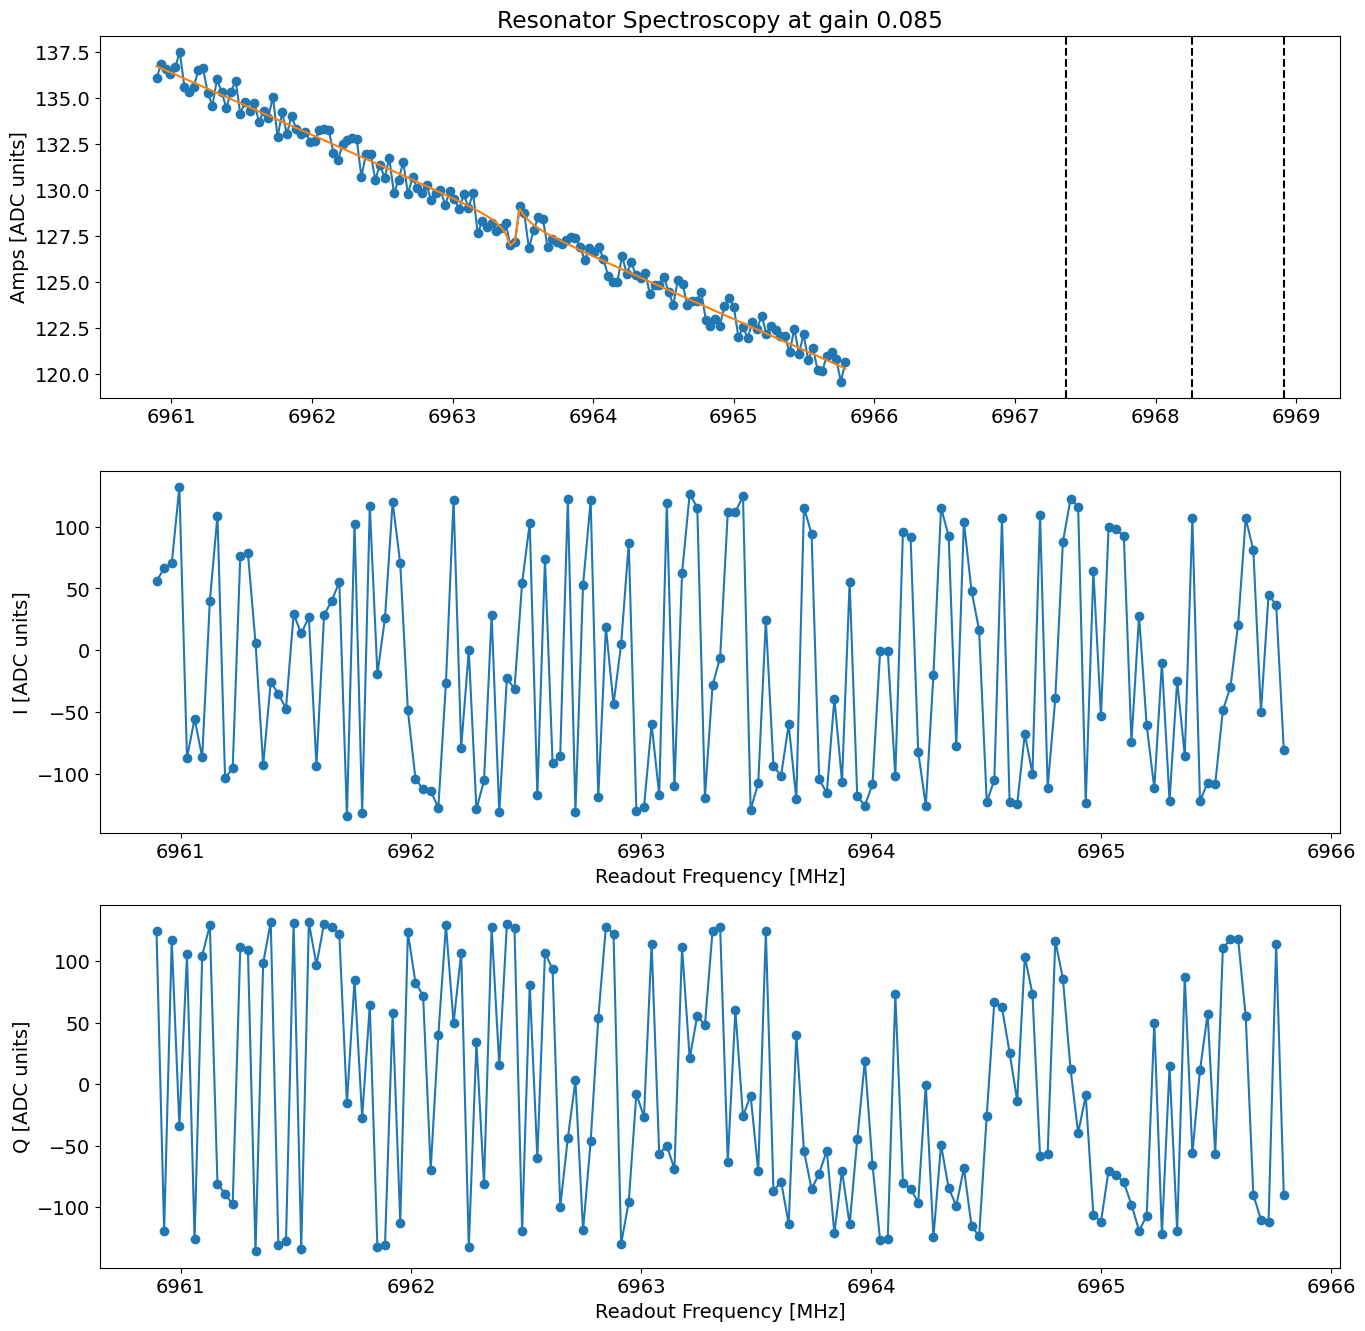

[{'Single shot g-e fidelity (%)': 41.78805960198673}, {'Qubit freq': 3450.7895590725893, 'Pi pulse len': 0.1, 'Pi pulse gain': 24945, 'T1': 88.01528902085553, 'T1 err': 2.3898312185719965, 'T2R': 44.15111045498067, 'T2R err': 1.962086656050886, 'T2E': 30.25929694612411, 'T2E err': 1.7462673977469687, 'Qubit EF freq': 3350.330233073566, 'EF pi pulse len': 0.04686378155276164, 'EF pi pulse gain': 29107, 'Qubit temp [mK]': 56.199674644449665, 'Single shot g-e fidelity (%)': 49.214973832461084}, {'Qubit freq': 4767.359704214145, 'Pi pulse len': 0.020886833661091352, 'Pi pulse gain': 2705, 'T1': 32.93056755583473, 'T1 err': 1.2325694970800454, 'T2R': 12.882410694681475, 'T2R err': 1.4701638837441797, 'T2E': 17.77399784383835, 'T2E err': 0.9103708488638977, 'Res chi shift (e - g)': 1.6390728476820868, 'Qubit EF freq': 4577.689960511519, 'EF pi pulse len': 0.022312951557475664, 'EF pi pulse gain': 1859, 'Qubit temp [mK]': 80.94855045625054, 'Single shot g-e fidelity (%)': 15.340511350378346, 

In [361]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [362]:
if save_data: saved_files.append(rspecEF_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00001_resonator_spectroscopy_chi_qubit3.h5


# Single Shot

## Single shot optimization

In [36]:
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [43]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

span_f = 1.0*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

# span_f = 2.5*abs(results_Qi['Res kappa']) # MHz
npts_f = 10

span_gain = 0
# npts_gain = 10
# span_gain = 0.08
# npts_gain = 8

# span_len = 8 # us
# npts_len = 2
span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    start_gain=shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2,
    # start_gain=0.05,
    # step_gain=span_gain/npts_gain,
    # expts_gain=npts_gain + 1,
    # start_gain=0.100,
    step_gain=0,
    expts_gain=1,

    start_len=3.0,
    step_len=span_len/npts_len,
    expts_len=npts_len,
    # start_len=2,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4115.729123641049, 3452.1272242129544, 4766.79101495888, 4386.167303500396], 'f_ef': [3887.651880298383, 3355.138705247387, 4576.9686517467035, 4213.341807614251], 'f_Q1_ZZ': [3446.870091628903, 0, 3451.0821174883786, 3450.8759319136634], 'f_Q_ZZ1': [4110.652798026172, 0, 4765.724697576131, 4384.873947538987], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5884.5, 5152.26], 'gs': [53.86111790753793, 55.951615253475715, 42.896055738679614, 1.2556674383426387, 2.535432566502201, 6.608656393450753], 'ZZs': [0.0, -5.205007385369981, -0.010203852149970771, -0.4154383205072918, -5.205007385369981, 0.0, -1.043339742074977, -1.2758593067444508, -0.010203852149970771, -1.043339742074977, 0.0, -0.494092272958369, -0.4154383205072918, -1.2758593067444508, -0.494092272958369, 0.0], 'T1': [45, 88, 55, 75], 'pulses': {'pi_ge': {'gain': [27778, 10954, 11495, 3869], 'sigma': [0.015, 0.015, 0.01, 0.01], 'half_gain': ['None', 'None', 'Non

  0%|          | 0/10 [00:00<?, ?it/s]

freq: 824.0910333333333, gain: 0.5, len: 3.0
	fid ge [%]: 55.868528950965036
freq: 824.1110333333332, gain: 0.5, len: 3.0
	fid ge [%]: 31.535435695713048
freq: 824.1310333333332, gain: 0.5, len: 3.0
	fid ge [%]: 29.014300476682557
freq: 824.1510333333332, gain: 0.5, len: 3.0
	fid ge [%]: 35.23450781692723
freq: 824.1710333333333, gain: 0.5, len: 3.0
	fid ge [%]: 33.361112037067905
freq: 824.1910333333333, gain: 0.5, len: 3.0
	fid ge [%]: 34.97566504433629
freq: 824.2110333333333, gain: 0.5, len: 3.0
	fid ge [%]: 34.26895126341756
freq: 824.2310333333332, gain: 0.5, len: 3.0
	fid ge [%]: 26.934231141038033
freq: 824.2510333333332, gain: 0.5, len: 3.0
	fid ge [%]: 27.575171678111875
freq: 824.2710333333332, gain: 0.5, len: 3.0
	fid ge [%]: 45.5148504950165


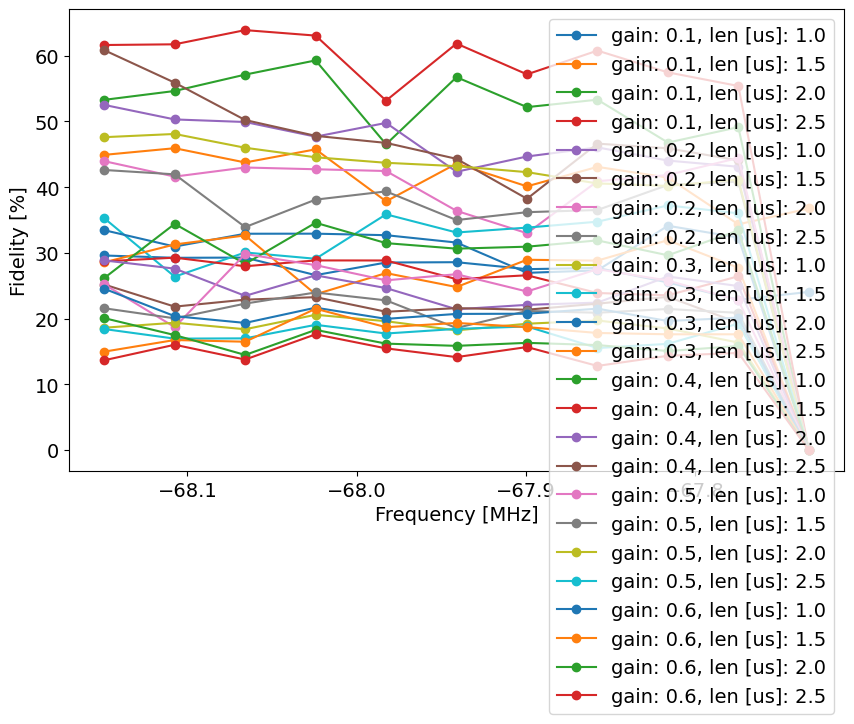

In [44]:

# Using readlines()
file1 = open('C:\\Users\\slab\\Downloads\\singleshot_opt.txt', 'r')
lines = file1.readlines()
freqs = []
gains = []
lengths = []
fids = []

line = lines[0]
words = line.split()
freq = float(words[1][:-1])
freqs.append(freq)
gain = float(words[3][:-1])
gains.append(gain)
length = float(words[5])
lengths.append(length)

fid_line = lines[1]
fids.append(float(fid_line.split()[3]))
 
# Strips the newline character
for i in range(2, len(lines), 2):
    line = lines[i]
    words = line.split()
    freq = float(words[1][:-1])
    if freq not in freqs: freqs.append(freq)
    gain = float(words[3][:-1])
    if gain not in gains: gains.append(gain)
    length = float(words[5])
    if length not in lengths: lengths.append(length)

    fid_line = lines[i+1]
    fids.append(float(fid_line.split()[3]))
    continue

fids = np.append(fids, [0]*22)
fids = np.reshape(fids, newshape=(len(freqs), len(gains), len(lengths)))

# lenpts = [data['lenpts'][0]]
for g_ind, gain in enumerate(gains):
    for l_ind, l in enumerate(lengths):
        plt.plot(freqs, fids[:,g_ind, l_ind], 'o-', label=f'gain: {gain:.2}, len [us]: {l}')
plt.xlabel('Frequency [MHz]')
plt.ylabel(f'Fidelity [%]')
plt.legend()
plt.show()


(0, 0, 0)
[824.09103333 824.11103333 824.13103333 824.15103333 824.17103333
 824.19103333 824.21103333 824.23103333 824.25103333 824.27103333]
[0.5]
[3.]
Max fidelity 55.868528950965036 %
Set params: 
 angle (deg) 141.51709195607393 
 threshold 52.32306387512864 
 freq [Mhz] 824.0910333333333 
 gain [dac units] 0.5 
 readout length [us] 3.0


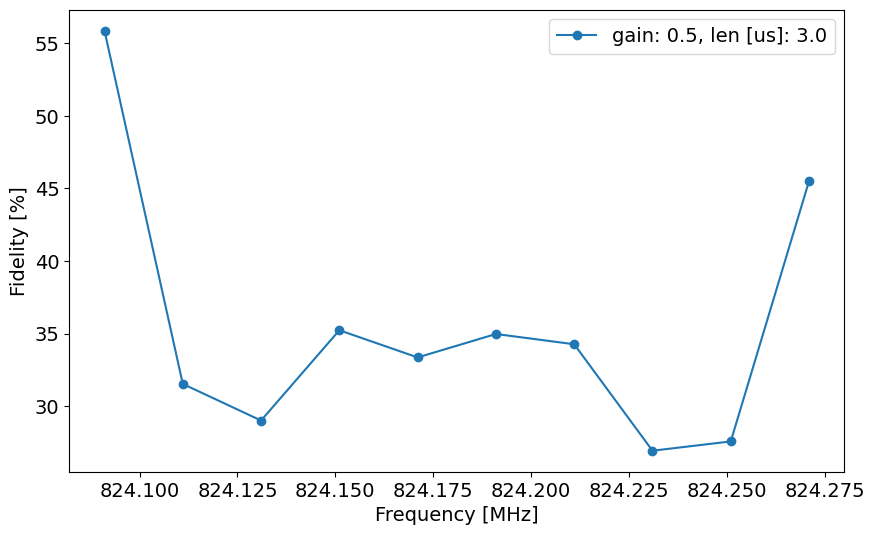

[[[0.55868529]]

 [[0.31535436]]

 [[0.290143  ]]

 [[0.35234508]]

 [[0.33361112]]

 [[0.34975665]]

 [[0.34268951]]

 [[0.26934231]]

 [[0.27575172]]

 [[0.4551485 ]]]


In [45]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [306]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit0.h5


next qubit

In [36]:
qubit_i = 2
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.6
npts_gain = 6

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.1,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=5,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [310]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit3.h5


next qubit

In [41]:
qubit_i = 3
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.1
npts_gain = 8

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=5,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [314]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit1.h5


## Best readout parameters

In [15]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=15000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=freq_opt
# shot.cfg.device.readout.gain[qubit_i]=gain_opt
# print(freq_opt, gain_opt)
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency = -816.25952299
# shot.cfg.device.readout.gain[qubit_i] = 0.025
# shot.cfg.device.readout.readout_length = 2

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain[qubit_i]=0.200
# shot.cfg.device.readout.readout_length = 1.5 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4115.729123641049, 3452.1272242129544, 4766.79101495888, 4386.167303500396], 'f_ef': [3887.651880298383, 3355.138705247387, 4576.9686517467035, 4213.341807614251], 'f_Q1_ZZ': [3446.870091628903, 0, 3451.0821174883786, 3450.8759319136634], 'f_Q_ZZ1': [4110.652798026172, 0, 4765.724697576131, 4384.873947538987], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5884.5, 5152.26], 'gs': [53.86111790753793, 55.951615253475715, 42.896055738679614, 1.2556674383426387, 2.535432566502201, 6.608656393450753], 'ZZs': [0.0, -5.205007385369981, -0.010203852149970771, -0.4154383205072918, -5.205007385369981, 0.0, -1.043339742074977, -1.2758593067444508, -0.010203852149970771, -1.043339742074977, 0.0, -0.494092272958369, -0.4154383205072918, -1.2758593067444508, -0.494092272958369, 0.0], 'T1': [45, 88, 55, 75], 'pulses': {'pi_ge': {'gain': [27778, 10954, 11495, 3869], 'sigma': [0.015, 0.015, 0.01, 0.01], 'half_gain': ['None', 'None', 'Non

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Unrotated:
Ig -185.1955579631636 +/- 41.362074485376276 	 Qg 99.25947995666306 +/- 47.897822074473986 	 Amp g 210.1186308982492
Ie -156.7567713976165 +/- 44.08395857867972 	 Qe 121.83423618634886 +/- 62.65513406951403 	 Amp e 198.5353028710905
Rotated:
Ig -82.85217136090341 +/- 41.362074485376276 	 Qg 193.18841545214934 +/- 47.897822074473986 	 Amp g 210.20524770834993
Ie -44.21402479223846 +/- 44.08395857867972 	 Qe 192.58508518883113 +/- 62.65513406951403 	 Amp e 197.59528087866377


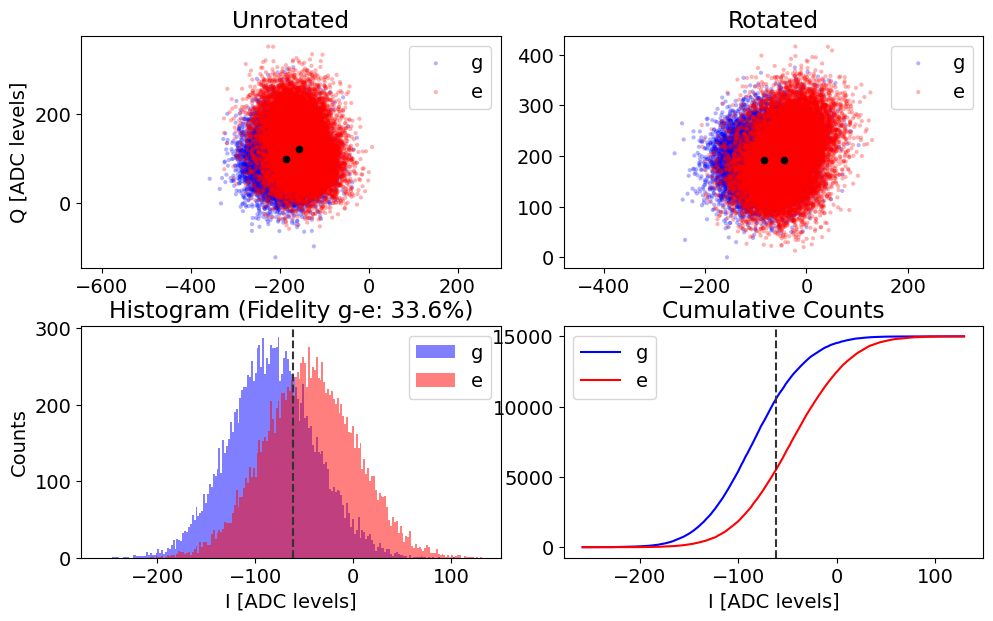

ge fidelity (%): 33.627787592919766
rotation angle (deg): -38.442604860866766
threshold ge: -61.58518426615245


In [16]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)
results_Qi.update({'Single shot g-e fidelity (%)': 100*shot.data['fids'][0]})

In [156]:
if save_data: saved_files.append(shot.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00000_single_shot_qubit2.h5


# Results

In [194]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)

{'device': {'qubit': {'f_ge': [4115.6290596912495, 3452.4637168981253, 4766.8208180553465, 4386.208444751211], 'f_ef': [3887.651880298383, 3350.3334827343665, 4577.0649811867825, 4213.292531164727], 'f_Q1_ZZ': [3445.584966358354, 0, 3449.6936121756476, 3449.4923401580063], 'f_Q_ZZ1': [4109.2353064588515, 0, 4766.250999229112, 4384.886209216403], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5892.7, 5151.85], 'gs': [53.07454288679892, 56.33900830945526, 44.06651851927302, 4.826787539590175, 2.201102542443888, 6.280490149923522], 'ZZs': [0.0, -5.132149880358156, -0.11720448229698377, -0.46755316331291397, -5.132149880358156, 0.0, -1.1258892837849999, -1.2798980910865794, -0.17297849, -1.1258892837849999, 0.0, -0.5808573560734658, -0.46704822, -1.2798980910865794, -0.4730200905169113, 0.0], 'T1': [50, 88, 42, 70.0], 'pulses': {'pi_ge': {'gain': [20665, 11064, 3681, 2574], 'sigma': [0.02, 0.015, 0.015, 0.015], 'half_gain': ['None', 'None', 'None', 'None'